In [1]:
from shelf.routing import RoutingProblem, Vehicle
from shelf.optimization import GeneticAlgorithm, Solver
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandapower as pp 
import pandapower.networks as pn
import copy
import itertools
import pickle
import numba

from pgmpy.models import BayesianNetwork
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.discrete import TabularCPD
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from numpy import exp

from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
import pandapower.topology as top
import pandapower.networks as pn
from sklearn.metrics import f1_score
import random
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.inference import CausalInference
from pgmpy.inference import ApproxInference
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import TabularCPD
from dbn_sep_multi_state import DBN_DS_MS
from dbn_sep_v2 import DBN_DS
import matplotlib as mpl
import api_pp as apipp
import failure_and_repair_model as frm
from lifelines import *
import scipy
from pytensor.tensor import TensorVariable

import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# Using a Bayesian Hierarchical Model to calculate the availability of a smart grid upon redundancies

## Step 0: choosing a power network to be modelled 

In [3]:
network=pp.from_pickle('londrina_por_setores.p')
network.bus

,name,vn_kv,type,zone,in_service,geo
0,1794352_566610,5.0,b,None,True,NaN
1,1937368_566610_567159,5.0,b,None,True,NaN
2,1938967_3013939_567159,5.0,b,None,True,NaN
3,1899127_1937368_2223680_2974102,5.0,b,None,True,NaN
4,1938967,5.0,b,None,True,NaN
5,1899127_3013939,5.0,b,None,True,NaN
6,1794298_1937130_3015399,5.0,b,None,True,NaN
7,3015399_561949,5.0,b,None,True,NaN
8,1794311_1937130_1937246_547598,5.0,b,None,True,NaN
9,1937246_2223680_561949,5.0,b,None,True,NaN


# Assumptions
* the process of islanding will be modelled by a single node in the DBN (receives_energy)
* the granularity for the system is a single sector, where sector is the subset of buses contained between two (or more) normally closed switches

In [17]:
lambda_s=0.5
mu_s=0.1
failure_rate=0.1


net=pp.from_pickle('londrina_por_setores.p')
bus_idx=5 #index of the bus (or sector) to be modelled as a dynamic bayesian network

#below we define the failure rate of each sector as lambda_s (but it can be customized later to have a failure rate for each sector)
failure_dict={}
for bus in net.bus.index:
    failure_dict[bus]=lambda_s

## Step 1: building the model

In [8]:
def build_model(failure_rate=0.01,repair_rate=0.4,average_demand=40,carregamento=0.8,ev_battery_size=24,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=10,individual_user_dict=None):  
    #hiperparameters 
    # failure rate and repair rate of the system 
    failure_rate=0.01 
    repair_rate=0.5



    # wind speed (ref: Optimal Integrated Energy System Planning With DG Uncertainty Affine Model and Carbon Emissions Charges)
    scale_weibull=9.86 #shape (alpha)
    shape_weibull=1.56 #scale (beta)
    v_ci=4 #cut-in wind speed
    v_ra=10 #rated wind speed
    v_co=22 #cut-out wind speed
    p_ra=300 #rated power of WT (varia entre 300 e 250 no artigo)

    # solar radiation (ref: Optimal Integrated Energy System Planning With DG Uncertainty Affine Model and Carbon Emissions Charges)
    a=7.5
    b=16.3
    i_max=2.9
    i_min=1.9

    # other solar radiations parameters (ref: Hybrid solar/wind power system probabilistic modelling for long-term performance assessment)
    sr_area=5 #typical area 

    #load deviation (ref: Automated Generation Algorithm for Synthetic Medium Voltage Radial Distribution Systems)
    loc=-0.001
    scale=0.002
    shape=1.46
    deviation=scipy.stats.nct(df=1,nc=shape,loc=loc,scale=scale).rvs(1)[0]

    # battery modelling (ref: A novel approach for optimal energy resources mixing in nuclear-renewable microgrids using probabilistic energy modelling method)
    n_cell=1
    a_d=35
    eff_inverter=0.95
    eff_battery=0.85
    dod=0.80
    d_max=100 #maximum distance

    ## EV modelling (ref: Probabilistic estimation of plug-in electric vehicles charging load profile)
    # maximum number of ev is defined before simulations

    # daily mileage is weibull:
    a_dm=32.029
    b_dm=1.23451

    # departure time is weibull
    a_dt=7.67
    b_dt=21.83

    # arrival time is generalized extreme value (cant model in pymc so I will use just weibull)
    # k_gev=-0.06
    #sigma_gev=0.85
    #mu_gev=17.3
    a_at=0.85
    b_at=17.3

    # current battery sizes for EV (ref: Probabilistic estimation of plug-in electric vehicles charging load profile)
    ev_battery_size=24 #kwh
    consumption_rate=0.23 #kwh/min

    #final values for mu and sigma over time
    mu_dict={
        '17':2885.1,
        '18':2493.9,
        '19':1818.6,
        '20':1105.05,
        '21':570.6,
        '22':263.25,
        '23':109.5,
        '24':40.35
    }

    sigma_dict={
        '17':51.8404,
        '18':121.435,
        '19':149.519,
        '20':142.494,
        '21':110.338,
        '22':87.7063,
        '23':61.691,
        '24':36.1651
    }

    #max capacities
    max_p_wt=50 #rated power of WT
    max_p_pv=50 #rater power of solar radiation
    average_feeder_capacity=average_demand/carregamento

    #max_cap_battery=n_cell*a_d*average_demand/(eff_inverter*eff_battery*dod)
    max_cap_battery=50

    #model parameters
    num_samples=10000
    num_chains=4


    # DEFINE THE CURRENT TIME (later I will change this since I want to use DBN)
    current_time=20

    model_dict={}

    for bus_idx in net.bus.index:
        graph_net=top.create_nxgraph(net)

        tabular_cpd=[]

        islanding_prob=1
        for gen_bus in net.gen.bus:
            path_list=list(nx.all_simple_paths(graph_net,gen_bus,bus_idx))
            produtorio_paths=1
            for path in path_list:
                len_path=len(path)
                produtorio=1
                for bus_path in path:
                    produtorio*=(1-failure_dict[bus_path]) # prob that a path is working
                produtorio_paths*=(1-produtorio) #prob that no path is working -> feeder can not attends demand of sector
            islanding_prob*=produtorio_paths # prob that no feeder can attend demand -> sector is islanded

        print('########## BUS {} ##########'.format(bus_idx))
        print(islanding_prob)
        
        with pm.Model() as model1:

            beta_wind = pm.Bernoulli('beta_wind', p=0.5)
            beta_solar = pm.Bernoulli('beta_solar', p=0.5)    
            beta_battery = pm.Bernoulli('beta_battery',p=0.5)
            receives_energy = pm.Bernoulli('receives_energy', p=1-islanding_prob)    

            #ev modelling (essa parte posso usar depois)
            #gev = pm.CustomDist('gev',k_gev,sigma_gev,mu_gev,logp=gev_logp)
            n_ev=pm.DiscreteUniform('n_ev',lower=0,upper=max_n_ev)
            beta_ev = pm.Bernoulli('beta_ev',p=0.5,shape=max_n_ev) #dps transformar isso num array pq quero modelar cada EV individualmente

            daily_mileage=pm.Weibull('daily_mileage',alpha=a_dm,beta=b_dm,shape=max_n_ev)
            if(individual_user_dict==None):
                arrival_time=pm.Weibull('arrival_time',alpha=a_at,beta=b_at,shape=max_n_ev)
                departure_time=pm.Weibull('departure_time',alpha=a_dt,beta=b_dt,shape=max_n_ev)
            else:
                for i in range(max_n_ev):
                    arrival_time=pm.Deterministic('arrival_time',individual_user_dict['arrival'],shape=max_n_ev)
                    departure_time=pm.Deterministic('departure_time',individual_user_dict['departure'],shape=max_n_ev)
                

            soc=1-daily_mileage/d_max

            charging_time=(1-soc)*consumption_rate/60 #charging time in hours

            available_power=soc*ev_battery_size+(current_time-arrival_time)*consumption_rate*60

            

            power_ev=pm.Deterministic('power_ev_array',pm.math.switch(beta_ev<0.5,-soc*ev_battery_size,pm.math.switch(departure_time-arrival_time>charging_time,available_power,0)))


            wind = pm.Weibull('wind',alpha=shape_weibull,beta=scale_weibull)
            #solar = (i_max-i_min)*pm.Beta('solar',alpha=a,beta=b)+i_min
            solar = (i_max-i_min)*pm.Beta('solar',alpha=a,beta=b)+i_min

            #capacity_wind = pm.Bound('capacity_wind',pm.Normal.dist(mu=beta_wind*max_p_wt*(wind**3-v_ci**3)/(v_ra**3-v_ci**3),sigma=1),lower=0.0)
            #capacity_solar = pm.Bound('capacity_solar',pm.Normal.dist(mu=beta_solar*(max_p_pv/i_max)*solar,sigma=1),lower=0.0)
            #capacity_feeder = pm.Bound('capacity_feeder',pm.Normal.dist(mu=average_feeder_capacity,sigma=1),lower=0.0)

            value_wind=max_p_wt*(wind**3-v_ci**3)/(v_ra**3-v_ci**3)

            true_value_wind=pm.math.switch(wind<v_ci,0,pm.math.switch(wind>=v_ci,pm.math.switch(wind<v_ra,value_wind,max_p_wt),max_p_wt))
            true_value_solar=pm.math.switch(sr_area*solar>max_p_pv,max_p_pv,sr_area*solar)
        
            capacity_wind=pm.Deterministic('capacity_wind',beta_wind*pm.math.switch(true_value_wind<0,0,true_value_wind))
            capacity_solar=pm.Deterministic('capacity_solar',beta_solar*true_value_solar)
            capacity_feeder=pm.Deterministic('capacity_feeder',receives_energy*average_feeder_capacity)
            capacity_battery=pm.Deterministic('capacity_battery',pm.math.switch(beta_battery>0.5,0,max_cap_battery))

            demand_deviation = pm.StudentT('demand_deviation',mu=loc,sigma=scale,nu=shape) 
            demand = pm.Bound('demand',pm.Normal.dist(mu=(1+demand_deviation)*average_demand,sigma=1),lower=0.0)

            energy_balance_with_battery  = pm.Deterministic('energy_balance_with_battery',capacity_battery+capacity_feeder+capacity_solar+capacity_wind+pm.math.sum(power_ev)-demand)
            energy_balance_no_battery = pm.Deterministic('energy_balance_no_battery',capacity_feeder+capacity_solar+capacity_wind+pm.math.sum(power_ev)-demand)

        model_dict[bus_idx]=copy.deepcopy(model1)

    return model_dict

    

# Step 2 - calculating probabilities from the posterior distribution

In [9]:
def create_dbn_from_model(model_dict,time_horizon,bus_idx,num_samples=10000,num_chains=4,max_n_ev=10,return_trace=False):
    with model_dict[bus_idx]:
        trace1 = pm.sample(draws=num_samples,chains=num_chains,tune=1000)

    availability_array=np.zeros((2,2,2,2,max_n_ev+1)) #for each binary combination of redundancies (including battery) + receives_energy + beta_ev 
    battery_array=np.zeros((2,2,2,2,max_n_ev+1,3))
    count_array=np.zeros((2,2,2,2,max_n_ev+1))

    [i,j]=trace1.posterior['energy_balance_with_battery'].shape

    for i in range(num_chains):
        for j in range(num_samples):
            receives_energy=int(trace1.posterior['receives_energy'][i][j])
            beta_solar=int(trace1.posterior['beta_solar'][i][j])
            beta_wind=int(trace1.posterior['beta_wind'][i][j])
            beta_battery=int(trace1.posterior['beta_battery'][i][j])
            beta_ev=int(sum(trace1.posterior['beta_ev'][i][j].values))


            
            #option 2: directly from the posterior distribution
            eb_with_battery=float(trace1.posterior['energy_balance_with_battery'][i][j])
            eb_without_battery=float(trace1.posterior['energy_balance_no_battery'][i][j])
        
            count_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev]+=1
            if(eb_without_battery>0): #this means that without battery there is still energy left so the battery is charged (state 2)
                availability_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev]+=1
                if(beta_battery==1):
                    battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][2]+=1 #charged
                else:
                    battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][1]+=1 #does nothing
                

            elif(eb_with_battery>0 and beta_battery==1): # this means that with battery it is possible to achieve the demand, and the battery is discharged (state 0)
                availability_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev]+=1
                battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][0]+=1
            else: #in all other cases the demand is not achieved (availability=0) and nothing happens to the battery (state 1)
                battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][1]+=1

    for i in range(availability_array.shape[0]):
        for j in range(availability_array.shape[1]):
            for k in range(availability_array.shape[2]):
                for l in range(availability_array.shape[3]):
                    for m in range(availability_array.shape[4]):
                        if(count_array[i][j][k][l][m]!=0):
                            availability_array[i][j][k][l][m]=availability_array[i][j][k][l][m]/count_array[i][j][k][l][m]
                            for state_battery in range(3):
                                battery_array[i][j][k][l][m][state_battery]=battery_array[i][j][k][l][m][state_battery]/count_array[i][j][k][l][m]
                        else:
                            availability_array[i][j][k][l][m]=0
                            battery_array[i][j][k][l][m][0]=0
                            battery_array[i][j][k][l][m][1]=1 #nothing happens (state 1)
                            battery_array[i][j][k][l][m][2]=0

    #availability 
    print('availability test!',availability_array[0][0][0][0][3])
    print('better availability test!',availability_array[0][1][1][1][3])
    state_cpd=[]
    for availability in range(2):
        linha_cpd=[]
        for receives_energy in range(2):
            for beta_solar in range(2):
                for beta_wind in range(2):
                    for beta_battery in range(2):
                        for beta_ev in range(max_n_ev+1):
                            if(availability==1):
                                linha_cpd.append(availability_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev])
                            else:
                                linha_cpd.append(1-availability_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev])


        state_cpd.append(linha_cpd)

    #battery state
    battery_state_cpd_list=[]

    for battery_state in range(3):
        linha_cpd=[]
        for receives_energy in range(2):
            for beta_solar in range(2):
                for beta_wind in range(2):
                    for beta_battery in range(2):
                        for beta_ev in range(max_n_ev+1):
                            if(battery_state==0):
                                linha_cpd.append(battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][0])
                            elif(battery_state==1):
                                linha_cpd.append(battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][1])
                            else:
                                linha_cpd.append(battery_array[receives_energy][beta_solar][beta_wind][beta_battery][beta_ev][2])

        battery_state_cpd_list.append(linha_cpd)


    # beta_battery t=1 (receives information of battery_used node in previous time step)
    beta_battery_1_cpd=[]
    for beta_battery_1 in range(2):
        linha_cpd=[]
        for beta_battery_0 in range(2):
            for battery_state in range(3):
                if(battery_state==0): #discharged
                    if(beta_battery_1==0):
                        linha_cpd.append(1)
                    else:
                        linha_cpd.append(0)
                elif(battery_state==1): #nothing happens with the battery
                    if(beta_battery_1==beta_battery_0):
                        linha_cpd.append(1)
                    else:
                        linha_cpd.append(0)
                else: #battery_state==2, battery is charged
                    if(beta_battery_1==1):
                        linha_cpd.append(1)
                    else:
                        linha_cpd.append(0)
        beta_battery_1_cpd.append(linha_cpd)

    # receives energy at t=1 (receives information of receives energy at t=0)
    receives_energy_1_cpd=[]
    for receives_energy_1 in range(2):
        linha_cpd=[]
        for receives_energy_0 in range(2):
            if(receives_energy_0==0): #node working normally in previous time step
                if(receives_energy_1==1):
                    linha_cpd.append(failure_rate)
                else:
                    linha_cpd.append(1-failure_rate)
            else: #node failed in previous time step
                if(receives_energy_1==1):
                    linha_cpd.append(1-repair_rate)
                else:
                    linha_cpd.append(repair_rate)
        receives_energy_1_cpd.append(linha_cpd)



    DBN_SG=BayesianNetwork()

    edges_to_add=[]

    #intratemporal edges for each time_step
    for t in range(time_horizon):
        edges_to_add.append(('beta_wind_{}'.format(t),'availability_{}'.format(t)))
        edges_to_add.append(('beta_solar_{}'.format(t),'availability_{}'.format(t)))
        edges_to_add.append(('beta_battery_{}'.format(t),'availability_{}'.format(t)))
        edges_to_add.append(('beta_ev_{}'.format(t),'availability_{}'.format(t)))
        edges_to_add.append(('receives_energy_{}'.format(t),'availability_{}'.format(t)))

        edges_to_add.append(('beta_wind_{}'.format(t),'battery_state_{}'.format(t)))
        edges_to_add.append(('beta_solar_{}'.format(t),'battery_state_{}'.format(t)))
        edges_to_add.append(('beta_battery_{}'.format(t),'battery_state_{}'.format(t)))
        edges_to_add.append(('beta_ev_{}'.format(t),'battery_state_{}'.format(t)))
        edges_to_add.append(('receives_energy_{}'.format(t),'battery_state_{}'.format(t)))

    #intertemporal edges for t>0
    for t in range(1,time_horizon):
        edges_to_add.append(('beta_battery_{}'.format(t-1),'beta_battery_{}'.format(t)))
        edges_to_add.append(('battery_state_{}'.format(t-1),'beta_battery_{}'.format(t)))
        edges_to_add.append(('receives_energy_{}'.format(t-1),'receives_energy_{}'.format(t)))


    DBN_SG.add_edges_from(edges_to_add)



    #node without any parents only for t=0
    beta_battery_cpd=TabularCPD('beta_battery_0',2,[[0.5],[0.5]])
    receives_energy_cpd=TabularCPD('receives_energy_0',2,[[0.5],[0.5]])
    DBN_SG.add_cpds(beta_battery_cpd)
    DBN_SG.add_cpds(receives_energy_cpd)

    #node without any parents for all time instants
    for t in range(time_horizon):
        beta_wind_cpd=TabularCPD('beta_wind_{}'.format(t),2,[[0.5],[0.5]])
        beta_solar_cpd=TabularCPD('beta_solar_{}'.format(t),2,[[0.5],[0.5]])
        beta_ev_cpd=TabularCPD('beta_ev_{}'.format(t),max_n_ev+1,[[(1/(max_n_ev+1))] for i in range(max_n_ev+1)])
        DBN_SG.add_cpds(beta_wind_cpd)
        DBN_SG.add_cpds(beta_solar_cpd)
        DBN_SG.add_cpds(beta_ev_cpd)




    # availability and battery state = nodes with parents for any t
    for t in range(time_horizon):
        availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
        battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
        DBN_SG.add_cpds(availability_cpd)
        DBN_SG.add_cpds(battery_state_cpd)
    # beta_battery and battery_state = nodes with parents for t>0
    for t in range(1,time_horizon):
        beta_battery_cpd=TabularCPD('beta_battery_{}'.format(t),2,beta_battery_1_cpd,evidence=['beta_battery_{}'.format(t-1),'battery_state_{}'.format(t-1)],evidence_card=[2,3])
        receives_energy_cpd=TabularCPD('receives_energy_{}'.format(t),2,receives_energy_1_cpd,evidence=['receives_energy_{}'.format(t-1)],evidence_card=[2])
        DBN_SG.add_cpds(beta_battery_cpd)
        DBN_SG.add_cpds(receives_energy_cpd)




    # checking model
    DBN_SG.check_model()

    if(return_trace==True):
        return [DBN_SG,trace1]
    else:
        return DBN_SG






In [15]:
model_dict=build_model()

########## BUS 0 ##########
0.31252229681759247


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883
########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


In [16]:
time_horizon=12
dbn_sg_dict={}
for bus_idx in net.bus.index:
    print('#################### BUS IDX {} ###################'.format(bus_idx))
    dbn_sg_dict[bus_idx]=create_dbn_from_model(model_dict,time_horizon,bus_idx,num_samples=10000)

#################### BUS IDX 0 ###################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


availability test! 0.8502415458937198
better availability test! 0.8414634146341463


NameError: name 'failure_rate' is not defined

## Final BN

# Some inference tests - forward inference - specific sector

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

DBN_SG=dbn_sg_dict[0]
solver = VariableElimination(DBN_SG)

max_n_ev=6

# no redundancy 
list_to_plot=[]
for i in range(max_n_ev+1):
    result = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    if(np.isnan(result.values[1])):
        list_to_plot.append(0)
    else:
        list_to_plot.append(result.values[1])
plt.plot(list_to_plot,'o-',label='No redundancy')

# adding wind 
list_to_plot=[]
for i in range(max_n_ev+1):
    result = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':1,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    if(np.isnan(result.values[1])):
        list_to_plot.append(0)
    else:
        list_to_plot.append(result.values[1])
plt.plot(list_to_plot,'o-',label='Wind-based DG')

# adding solar 
list_to_plot=[]
for i in range(max_n_ev+1):
    result = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':1,'beta_battery_0':0,'receives_energy_0':0})
    if(np.isnan(result.values[1])):
        list_to_plot.append(0)
    else:
        list_to_plot.append(result.values[1])
plt.plot(list_to_plot,'o-',label='Solar-based DG')

# adding battery
list_to_plot=[]
for i in range(max_n_ev+1):
    result = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':1,'receives_energy_0':0})
    if(np.isnan(result.values[1])):
        list_to_plot.append(0)
    else:
        list_to_plot.append(result.values[1])
plt.plot(list_to_plot,'o-',label='Battery')

# adding battery
list_to_plot=[]
for i in range(max_n_ev+1):
    result = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':1,'beta_solar_0':1,'beta_battery_0':1,'receives_energy_0':0})
    if(np.isnan(result.values[1])):
        list_to_plot.append(0)
    else:
        list_to_plot.append(result.values[1])
plt.plot(list_to_plot,'o-',label='Everything')
print(list_to_plot)


plt.legend()
plt.xlabel('Number of EVs',fontsize=14)
plt.ylabel('Availability',fontsize=14)
plt.xticks(range(max_n_ev+1),fontsize=14)
plt.show()

KeyError: 0

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]

solver = VariableElimination(DBN_SG)

max_n_ev=9


# adding wind 
list_to_plot=[]
for i in range(max_n_ev+1):
    result_no_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    result_with_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':1,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    diff=result_with_resource.values[1]-result_no_resource.values[1]
    if(np.isnan(diff)):
        list_to_plot.append(0)
    else:
        list_to_plot.append(diff)
plt.plot(list_to_plot,'o-',label='Wind-based DG')

# adding solar 
list_to_plot=[]
for i in range(max_n_ev+1):
    result_no_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    result_with_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':1,'beta_battery_0':0,'receives_energy_0':0})
    diff=result_with_resource.values[1]-result_no_resource.values[1]
    if(np.isnan(diff)):
        list_to_plot.append(0)
    else:
        list_to_plot.append(diff)
plt.plot(list_to_plot,'x-',label='Solar-based DG')

# adding battery
list_to_plot=[]
for i in range(max_n_ev+1):
    result_no_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':0,'receives_energy_0':0})
    result_with_resource = solver.query(variables=['availability_0'],evidence={'beta_ev_0':i,'beta_wind_0':0,'beta_solar_0':0,'beta_battery_0':1,'receives_energy_0':0})
    diff=result_with_resource.values[1]-result_no_resource.values[1]
    if(np.isnan(diff)):
        list_to_plot.append(0)
    else:
        list_to_plot.append(diff)
plt.plot(list_to_plot,'^-',label='battery')


plt.legend()
plt.xlabel('Number of EVs',fontsize=14)
plt.ylabel('Increase in availability',fontsize=14)
plt.xticks(range(max_n_ev+1),fontsize=14)
plt.title('Increase in availability when allocating redundancies')
plt.show()

NameError: name 'DBN_SG' is not defined

# Some results by each individual sector 
* for each redundancy, how is the availability increase for each electrical sector, depending on the number of EVs

In [ ]:
n_ev_list=[1,4,7,10]

to_plot_dict={}


for n_ev in n_ev_list:
    to_plot_dict[n_ev]={'wind':[],
                        'solar':[],
                        'battery':[]}
    for bus_idx in net.bus.index:

        DBN_SG=dbn_sg_dict[bus_idx]
        solver = VariableElimination(DBN_SG)

        plt.rcParams['figure.figsize'] = [8, 6]

        solver = VariableElimination(DBN_SG)
        
        to_plot_list_wind=[]
        to_plot_list_solar=[]
        to_plot_list_battery=[]
        for t in range(time_horizon):
            # adding wind 
            result_no_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):1,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            diff=result_with_resource.values[1]-result_no_resource.values[1]
            if(np.isnan(diff)):
                to_plot_list_wind.append(0)
            else:
                to_plot_list_wind.append(diff)

            # adding solar
            result_no_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):1,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            diff=result_with_resource.values[1]-result_no_resource.values[1]
            if(np.isnan(diff)):
                to_plot_list_solar.append(0)
            else:
                to_plot_list_solar.append(diff)

            # adding battery
            result_no_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):1,'receives_energy_{}'.format(t):0})
            diff=result_with_resource.values[1]-result_no_resource.values[1]
            if(np.isnan(diff)):
                to_plot_list_battery.append(0)
            else:
                to_plot_list_battery.append(diff)

        to_plot_dict[n_ev]['wind'].append(np.mean(to_plot_list_wind))
        to_plot_dict[n_ev]['solar'].append(np.mean(to_plot_list_solar))
        to_plot_dict[n_ev]['battery'].append(np.mean(to_plot_list_battery))

KeyError: 0

KeyError: 4

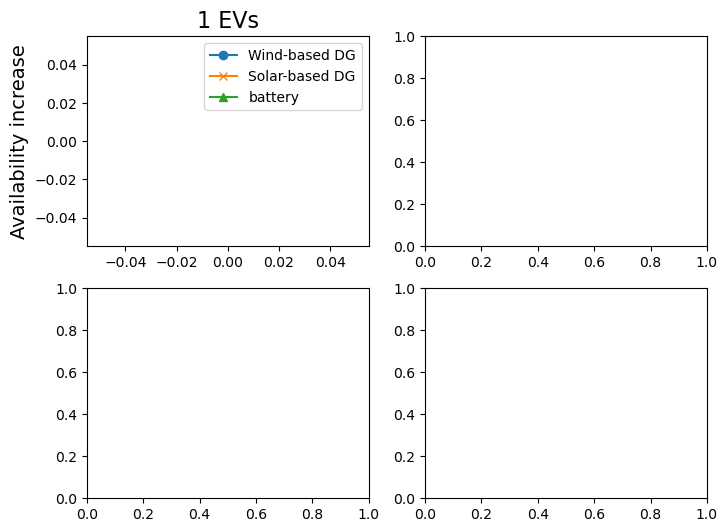

In [ ]:

fig, axes = plt.subplots(2,2)
n_ev=n_ev_list[0]
axes[0][0].plot(to_plot_dict[n_ev]['wind'],'o-',label='Wind-based DG')
axes[0][0].plot(to_plot_dict[n_ev]['solar'],'x-',label='Solar-based DG')
axes[0][0].plot(to_plot_dict[n_ev]['battery'],'^-',label='battery')
axes[0][0].set_title('{} EVs'.format(n_ev),fontsize=16)
axes[0][0].set_ylabel('Availability increase',fontsize=14)
axes[0][0].legend()

n_ev=n_ev_list[1]
axes[0][1].plot(to_plot_dict[n_ev]['wind'],'o-',label='Wind-based DG')
axes[0][1].plot(to_plot_dict[n_ev]['solar'],'x-',label='Solar-based DG')
axes[0][1].plot(to_plot_dict[n_ev]['battery'],'^-',label='battery')
axes[0][1].set_title('{} EVs'.format(n_ev),fontsize=16)
#axes[0][1].set_ylabel('Probability',fontsize=14)

n_ev=n_ev_list[2]
axes[1][0].plot(to_plot_dict[n_ev]['wind'],'o-',label='Wind-based DG')
axes[1][0].plot(to_plot_dict[n_ev]['solar'],'x-',label='Solar-based DG')
axes[1][0].plot(to_plot_dict[n_ev]['battery'],'^-',label='battery')
axes[1][0].set_title('{} EVs'.format(n_ev),fontsize=16)
axes[1][0].set_ylabel('Availability increase',fontsize=14)
axes[1][0].set_xlabel('Sector number',fontsize=14)

n_ev=n_ev_list[3]
axes[1][1].plot(to_plot_dict[n_ev]['wind'],'o-',label='Wind-based DG')
axes[1][1].plot(to_plot_dict[n_ev]['solar'],'x-',label='Solar-based DG')
axes[1][1].plot(to_plot_dict[n_ev]['battery'],'^-',label='battery')
axes[1][1].set_title('{} EVs'.format(n_ev),fontsize=16)
#axes[1][1].set_ylabel('Probability',fontsize=14)
axes[1][1].set_xlabel('Sector number',fontsize=14)



#plt.xlabel('Sector',fontsize=14)
#plt.ylabel('Increase in availability',fontsize=14)
#plt.xticks(range(len([0,1])),fontsize=14)
plt.tight_layout()
plt.show()

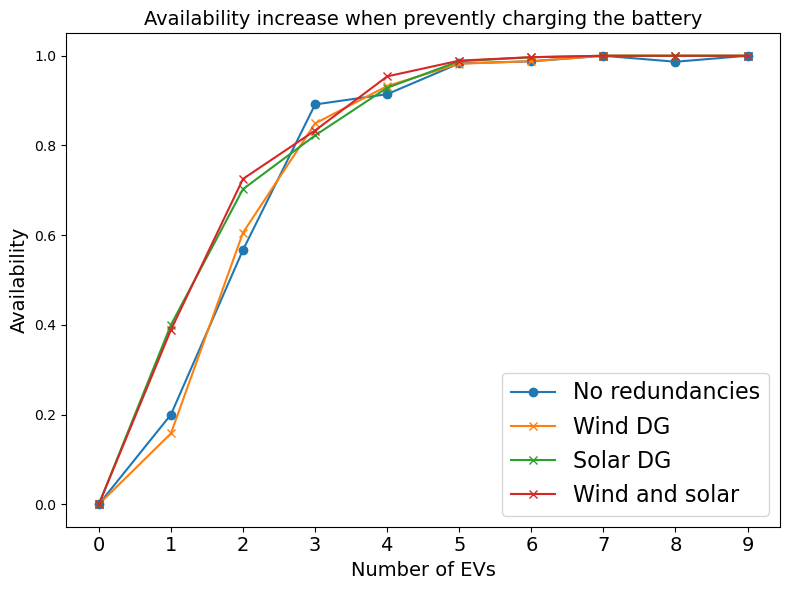

In [726]:
solver = VariableElimination(DBN_SG)

plt.rcParams['figure.figsize'] = [8, 6]

n_ev_list=range(10)

style_dict={
    0:'o-',
    1:'x-',
    2:'^-'
}

# no redundancies
to_plot_list=[]
for n_ev in n_ev_list:
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(to_plot_list,style_dict[0],label='No redundancies')



# wind DG
to_plot_list=[]
for n_ev in n_ev_list:
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(to_plot_list,style_dict[1],label='Wind DG')

# solar DG
to_plot_list=[]
for n_ev in n_ev_list:
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(to_plot_list,style_dict[1],label='Solar DG')


# wind and solar
to_plot_list=[]
for n_ev in n_ev_list:
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(to_plot_list,style_dict[1],label='Wind and solar')



plt.legend(fontsize=16)
plt.xlabel('Number of EVs',fontsize=14)
plt.ylabel('Availability',fontsize=14)
plt.xticks(n_ev_list,fontsize=14)
plt.title('Availability increase when prevently charging the battery',fontsize=14)
plt.tight_layout()
plt.show()

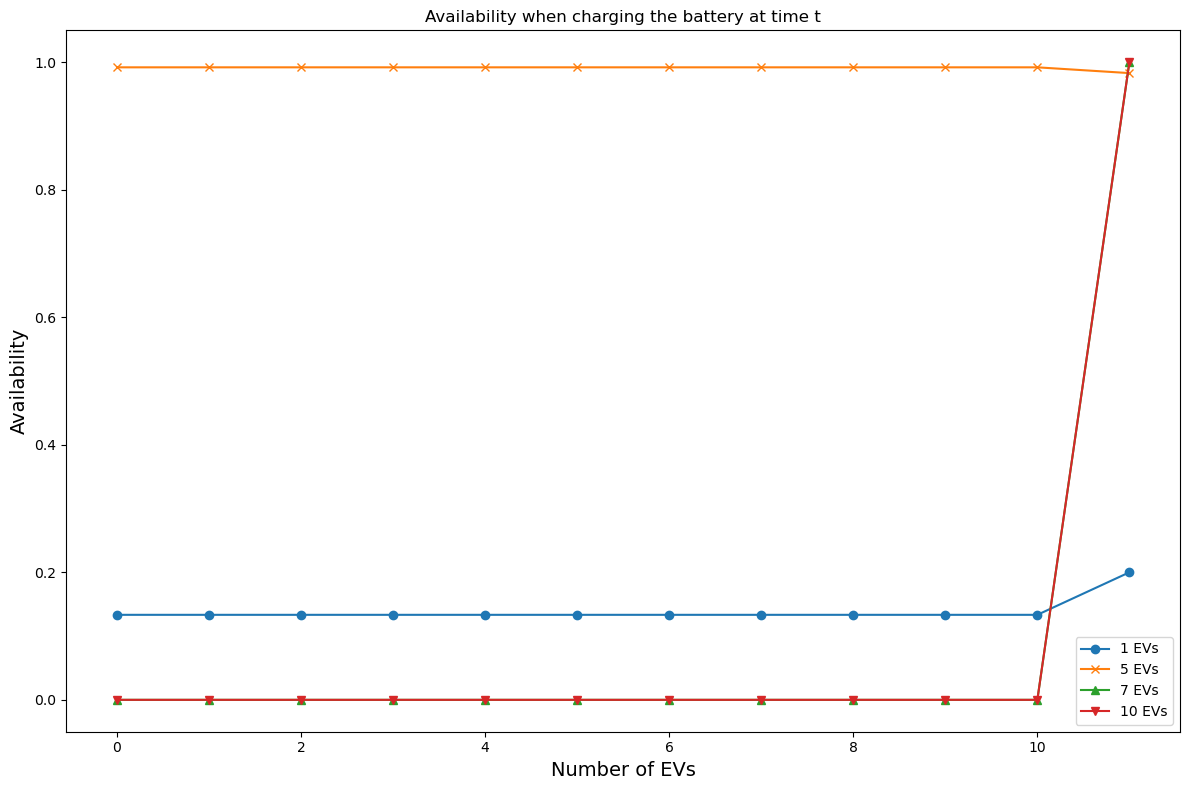

In [710]:
solver = VariableElimination(DBN_SG)

n_ev_list=[1,5,7,10]

style_dict={
    n_ev_list[0]:'o-',
    n_ev_list[1]:'x-',
    n_ev_list[2]:'^-',
    n_ev_list[3]:'v-'
}

# no redundancies

for n_ev in n_ev_list:
    to_plot_list=[]
    for t in range(12):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        for t_temp in range(12):
            if(t_temp==t):
                evidence['beta_battery_{}'.format(t)]=1
                evidence['battery_state_{}'.format(t)]=2
            else:
                evidence['beta_battery_{}'.format(t)]=0
                evidence['battery_state_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            to_plot_list.append(0)
        else:
            to_plot_list.append(value)           
    plt.plot(to_plot_list,style_dict[n_ev],label='{} EVs'.format(n_ev))



plt.legend()
plt.xlabel('Number of EVs',fontsize=14)
plt.ylabel('Availability',fontsize=14)
#plt.xticks(n_ev_list,fontsize=14)
plt.title('Availability when charging the battery at time t')
plt.tight_layout()
plt.show()

# Optimal number of EVs to allocate

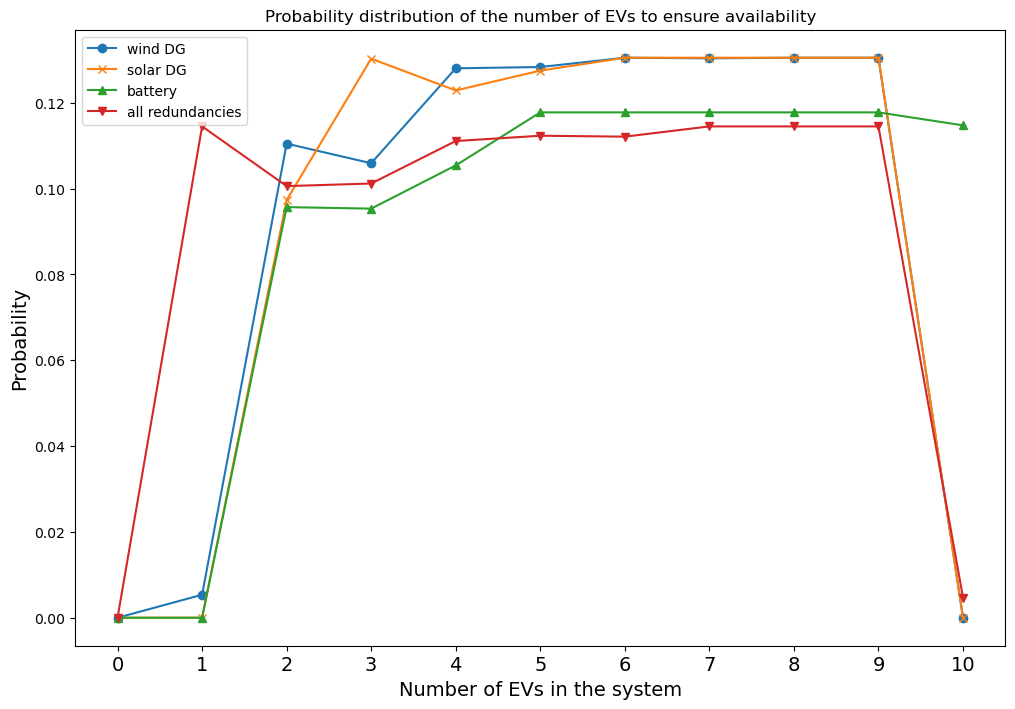

In [702]:

solver = VariableElimination(DBN_SG)


style_dict={
    0:'o-',
    1:'x-',
    2:'^-',
    3:'v-'
}


style_dict_idx=0

# only wind
evidence={}
for t in range(time_horizon):
    evidence['availability_{}'.format(t)]=1 
    evidence['beta_battery_{}'.format(t)]=0 
    evidence['beta_wind_{}'.format(t)]=1 
    evidence['beta_solar_{}'.format(t)]=0 

result_inference = solver.query(variables=['beta_ev_{}'.format(t)],evidence=evidence)

plt.plot(result_inference.values,style_dict[style_dict_idx],label='wind DG'.format(n_ev))
style_dict_idx+=1

# only solar
evidence={}
for t in range(time_horizon):
    evidence['availability_{}'.format(t)]=1 
    evidence['beta_battery_{}'.format(t)]=0 
    evidence['beta_wind_{}'.format(t)]=0 
    evidence['beta_solar_{}'.format(t)]=1 

result_inference = solver.query(variables=['beta_ev_{}'.format(t)],evidence=evidence)

plt.plot(result_inference.values,style_dict[style_dict_idx],label='solar DG'.format(n_ev))
style_dict_idx+=1

# only battery
evidence={}
for t in range(time_horizon):
    evidence['availability_{}'.format(t)]=1 
    evidence['beta_battery_{}'.format(t)]=1 
    evidence['beta_wind_{}'.format(t)]=0 
    evidence['beta_solar_{}'.format(t)]=0 

result_inference = solver.query(variables=['beta_ev_{}'.format(t)],evidence=evidence)

plt.plot(result_inference.values,style_dict[style_dict_idx],label='battery'.format(n_ev))
style_dict_idx+=1

# all redundancies
evidence={}
for t in range(time_horizon):
    evidence['availability_{}'.format(t)]=1 
    evidence['beta_battery_{}'.format(t)]=1 
    evidence['beta_wind_{}'.format(t)]=1 
    evidence['beta_solar_{}'.format(t)]=1 

result_inference = solver.query(variables=['beta_ev_{}'.format(t)],evidence=evidence)

plt.plot(result_inference.values,style_dict[style_dict_idx],label='all redundancies'.format(n_ev))
style_dict_idx+=1




plt.legend()
plt.xlabel('Number of EVs in the system',fontsize=14)
plt.ylabel('Probability',fontsize=14)
plt.xticks(range(max_n_ev+1),fontsize=14)
plt.title('Probability distribution of the number of EVs to ensure availability')
plt.show()

# 'what is the best combination of resources for a given sector'
* considering availability probability
* also considering number of evs

In [266]:
#DG characteristics (ref: Optimal Integrated Energy System Planning With DG Uncertainty Affine Model and Carbon Emissions Charges)
# capacity (kW) (maximum capacity)
# NOx/SO2/CO2 emission factors (in lb/MWh)
# capital cost (cc) ($/kW/hr)
# Operational and maintenance cost (om) ($/kW/hr)
# fuel cost (fc) ($/kW/hr)
# type (grid for normal gen; pv for solar based; wt for wind based; gt for fuel based)
# lifetime (year)
dg_info_dict={}
dg_info_dict['grid']={'lifetime':25,'fc':0.044,'cc':0,'om':0,'no2_emission':5.06,'so2_emission':11.6,'co2_emission':2031}
dg_info_dict['pv']={'max_capacity':1,'lifetime':20,'fc':0,'cc':3985,'om':0.01207,'no2_emission':0,'so2_emission':0,'co2_emission':0}
dg_info_dict['wt']={'max_capacity':5,'lifetime':20,'fc':0,'cc':1822,'om':0.00952,'no2_emission':0,'so2_emission':0,'co2_emission':0}
dg_info_dict['gt']={'max_capacity':3,'lifetime':12,'fc':0.0667,'cc':1224,'om':0.06481,'no2_emission':0.279,'so2_emission':0.93,'co2_emission':1239.2}


## 1 EV

In [518]:
n_ev_list=[1,4,7,10]

to_plot_dict={}


n_ev=1

df_dict={}
for bus_idx in net.bus.index:
    df_dict[bus_idx]=pd.DataFrame(columns=['beta_wind','beta_solar','beta_battery','availability_prob'])
    DBN_SG=dbn_sg_dict[bus_idx]
    solver = VariableElimination(DBN_SG)

    plt.rcParams['figure.figsize'] = [8, 6]

    solver = VariableElimination(DBN_SG)
    
    for beta_wind in range(2):
        for beta_solar in range(2):
            for beta_battery in range(2):
                availability_list=[]
                for t in range(12):
                    # adding wind 
                    result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):beta_wind,'beta_solar_{}'.format(t):beta_solar,'beta_battery_{}'.format(t):beta_battery})
                    diff=result_with_resource.values[1]
                    if(np.isnan(diff)):
                        availability_list.append(0)
                    else:
                        availability_list.append(diff)

                df_dict[bus_idx].loc[len(df_dict[bus_idx])]=[beta_wind,beta_solar,beta_battery,np.mean(availability_list)]

df_best_option=pd.DataFrame(columns=['sector','beta_wind','beta_solar','beta_battery','availability_prob','availability_increase'])
for bus_idx in net.bus.index:
    max_availability=df_dict[bus_idx].availability_prob.max()
    max_combination=list(df_dict[bus_idx][df_dict[bus_idx].availability_prob == max_availability].values[0])
    min_availability=df_dict[bus_idx].at[0,'availability_prob']
    df_best_option.loc[len(df_best_option)]=[bus_idx]+max_combination+[100*(max_availability-min_availability)]
df_best_option

,sector,beta_wind,beta_solar,beta_battery,availability_prob,availability_increase
0,0.0,1.0,1.0,0.0,0.414507,25.859551
1,1.0,1.0,0.0,1.0,0.643133,41.592069
2,2.0,1.0,1.0,0.0,0.653440,54.152820
3,3.0,0.0,1.0,1.0,0.940550,64.986402
4,4.0,1.0,1.0,0.0,0.411052,25.220294
5,5.0,1.0,1.0,0.0,0.965503,80.628869
6,6.0,1.0,1.0,1.0,0.453551,3.177821
7,7.0,1.0,1.0,1.0,0.497851,19.476199
8,8.0,1.0,1.0,1.0,0.494767,9.980247
9,9.0,1.0,1.0,1.0,0.496571,10.264784


# 3 EVs

In [519]:
n_ev_list=[1,4,7,10]

to_plot_dict={}


n_ev=3

df_dict={}
for bus_idx in net.bus.index:
    df_dict[bus_idx]=pd.DataFrame(columns=['beta_wind','beta_solar','beta_battery','availability_prob'])
    DBN_SG=dbn_sg_dict[bus_idx]
    solver = VariableElimination(DBN_SG)

    plt.rcParams['figure.figsize'] = [8, 6]

    solver = VariableElimination(DBN_SG)
    
    for beta_wind in range(2):
        for beta_solar in range(2):
            for beta_battery in range(2):
                availability_list=[]
                for t in range(12):
                    # adding wind 
                    result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):beta_wind,'beta_solar_{}'.format(t):beta_solar,'beta_battery_{}'.format(t):beta_battery})
                    diff=result_with_resource.values[1]
                    if(np.isnan(diff)):
                        availability_list.append(0)
                    else:
                        availability_list.append(diff)

                df_dict[bus_idx].loc[len(df_dict[bus_idx])]=[beta_wind,beta_solar,beta_battery,np.mean(availability_list)]

df_best_option=pd.DataFrame(columns=['sector','beta_wind','beta_solar','beta_battery','availability_prob','availability_increase'])
for bus_idx in net.bus.index:
    max_availability=df_dict[bus_idx].availability_prob.max()
    max_combination=list(df_dict[bus_idx][df_dict[bus_idx].availability_prob == max_availability].values[0])
    min_availability=df_dict[bus_idx].at[0,'availability_prob']
    df_best_option.loc[len(df_best_option)]=[bus_idx]+max_combination+[100*(max_availability-min_availability)]
df_best_option

,sector,beta_wind,beta_solar,beta_battery,availability_prob,availability_increase
0,0.0,0.0,0.0,1.0,0.889232,0.778727
1,1.0,1.0,0.0,1.0,0.872129,1.979750
2,2.0,1.0,1.0,1.0,0.918072,4.681981
3,3.0,0.0,1.0,1.0,0.901749,7.466471
4,4.0,1.0,1.0,1.0,0.900371,3.875994
5,5.0,0.0,0.0,1.0,0.915515,7.700043
6,6.0,1.0,1.0,1.0,0.918249,12.849848
7,7.0,1.0,1.0,0.0,0.894798,2.663680
8,8.0,1.0,0.0,1.0,0.934769,9.626539
9,9.0,0.0,1.0,1.0,0.919060,13.236443


# 6 EVs (saturacao)

In [520]:
n_ev_list=[1,4,7,10]

to_plot_dict={}


n_ev=6

df_dict={}
for bus_idx in net.bus.index:
    df_dict[bus_idx]=pd.DataFrame(columns=['beta_wind','beta_solar','beta_battery','availability_prob'])
    DBN_SG=dbn_sg_dict[bus_idx]
    solver = VariableElimination(DBN_SG)

    plt.rcParams['figure.figsize'] = [8, 6]

    solver = VariableElimination(DBN_SG)
    
    for beta_wind in range(2):
        for beta_solar in range(2):
            for beta_battery in range(2):
                availability_list=[]
                for t in range(12):
                    # adding wind 
                    result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):beta_wind,'beta_solar_{}'.format(t):beta_solar,'beta_battery_{}'.format(t):beta_battery})
                    diff=result_with_resource.values[1]
                    if(np.isnan(diff)):
                        availability_list.append(0)
                    else:
                        availability_list.append(diff)

                df_dict[bus_idx].loc[len(df_dict[bus_idx])]=[beta_wind,beta_solar,beta_battery,np.mean(availability_list)]

df_best_option=pd.DataFrame(columns=['sector','beta_wind','beta_solar','beta_battery','availability_prob','availability_increase'])
for bus_idx in net.bus.index:
    max_availability=df_dict[bus_idx].availability_prob.max()
    max_combination=list(df_dict[bus_idx][df_dict[bus_idx].availability_prob == max_availability].values[0])
    min_availability=df_dict[bus_idx].at[0,'availability_prob']
    df_best_option.loc[len(df_best_option)]=[bus_idx]+max_combination+[100*(max_availability-min_availability)]
df_best_option

,sector,beta_wind,beta_solar,beta_battery,availability_prob,availability_increase
0,0.0,0.0,0.0,0.0,0.996938,0.000000
1,1.0,0.0,1.0,0.0,0.999916,0.811722
2,2.0,0.0,1.0,0.0,0.999913,0.692478
3,3.0,0.0,1.0,1.0,1.000000,1.813152
4,4.0,0.0,1.0,0.0,0.999872,0.552526
5,5.0,0.0,0.0,1.0,1.000000,0.692484
6,6.0,0.0,1.0,0.0,0.999909,0.987911
7,7.0,1.0,1.0,1.0,0.999892,1.968740
8,8.0,0.0,0.0,0.0,0.999810,0.000000
9,9.0,0.0,1.0,0.0,0.999784,0.026857


# Taking the mean for each sector 
* this is to show what the best possible combination of resources can do in a given electrical system considering the presence of EVs

In [534]:
max_to_plot_list=[]
min_to_plot_list=[]
df_best_option_dict={}
for n_ev in range(11):
    df_dict={}
    for bus_idx in net.bus.index:
        df_dict[bus_idx]=pd.DataFrame(columns=['beta_wind','beta_solar','beta_battery','availability_prob'])
        DBN_SG=dbn_sg_dict[bus_idx]
        solver = VariableElimination(DBN_SG)

        plt.rcParams['figure.figsize'] = [8, 6]

        solver = VariableElimination(DBN_SG)
        
        for beta_wind in range(2):
            for beta_solar in range(2):
                for beta_battery in range(2):
                    availability_list=[]
                    for t in range(12):
                        # adding wind 
                        result_with_resource = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):beta_wind,'beta_solar_{}'.format(t):beta_solar,'beta_battery_{}'.format(t):beta_battery})
                        diff=result_with_resource.values[1]
                        if(np.isnan(diff)):
                            availability_list.append(0)
                        else:
                            availability_list.append(diff)

                    df_dict[bus_idx].loc[len(df_dict[bus_idx])]=[beta_wind,beta_solar,beta_battery,np.mean(availability_list)]

    df_best_option=pd.DataFrame(columns=['sector','beta_wind','beta_solar','beta_battery','availability_prob','availability_increase'])
    max_temp_to_plot_list=[]
    min_temp_to_plot_list=[]
    for bus_idx in net.bus.index:
        max_availability=df_dict[bus_idx].availability_prob.max()
        max_combination=list(df_dict[bus_idx][df_dict[bus_idx].availability_prob == max_availability].values[0])
        min_availability=df_dict[bus_idx].at[0,'availability_prob']
        df_best_option.loc[len(df_best_option)]=[bus_idx]+max_combination+[100*(max_availability-min_availability)]
        max_temp_to_plot_list.append(max_availability)
        min_temp_to_plot_list.append(min_availability)
    df_best_option_dict[n_ev]=df_best_option

    max_to_plot_list.append(np.mean(max_temp_to_plot_list))
    min_to_plot_list.append(np.mean(min_temp_to_plot_list))



In [536]:
max_availability

1.0

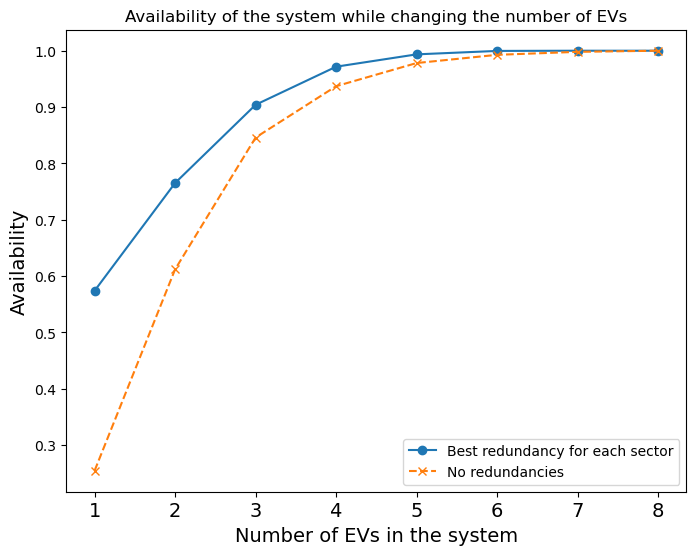

In [537]:
plt.plot(range(1,max_n_ev),np.array(max_to_plot_list[ 1:9]),'o-',label='Best redundancy for each sector')
plt.plot(range(1,max_n_ev),np.array(min_to_plot_list[ 1:9]),'x--',label='No redundancies')
plt.legend()
plt.xlabel('Number of EVs in the system',fontsize=14)
plt.ylabel('Availability',fontsize=14)
plt.xticks(range(1,max_n_ev),fontsize=14)
plt.title('Availability of the system while changing the number of EVs')
plt.show()

## qual foi a melhor escolha pra cada setor enquanto varia o numero de EVs


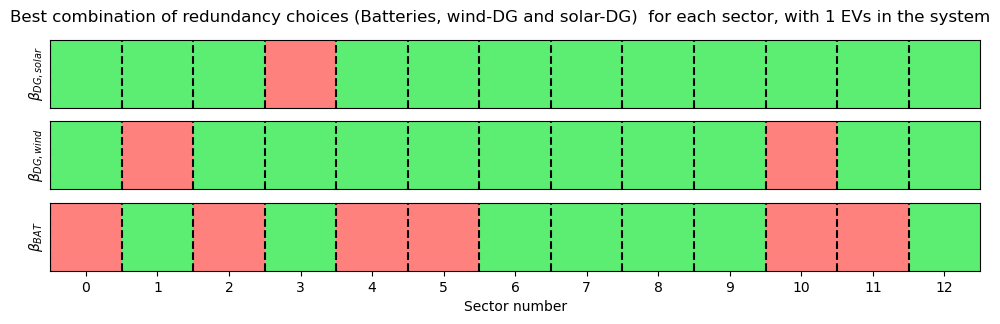

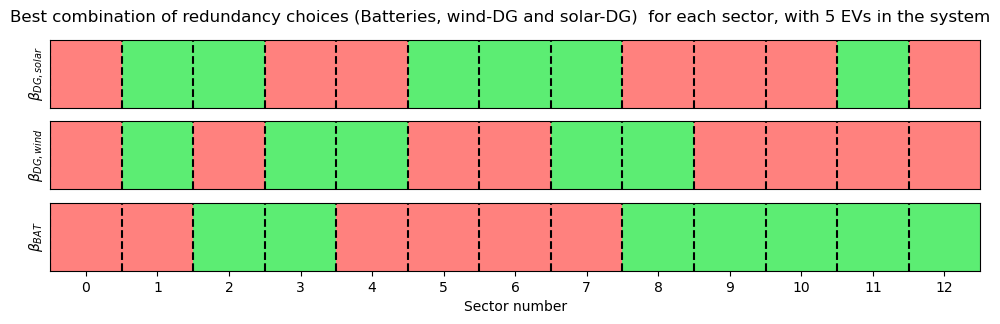

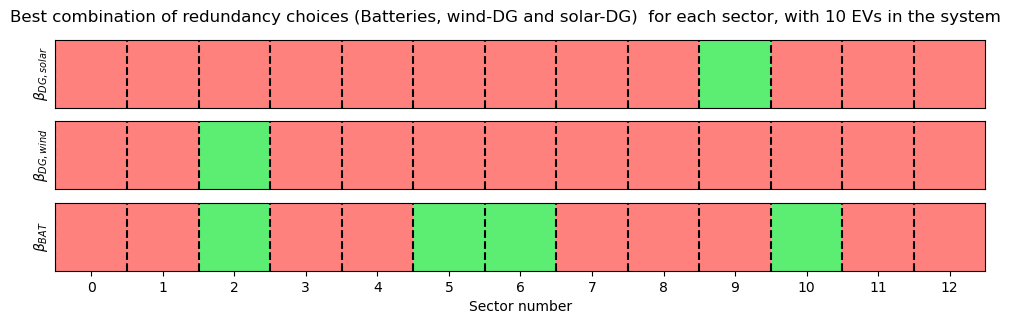

In [647]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


for n_ev in [1,5,10]:

    fig, axes = plt.subplots(3,1,figsize=(12,3))
    face_color_dict={
        0:'#FF817E',
        1:'#5ced73'
        }


    # rectangle 1 - wind 


    for sector in range(len(net.bus.index)):
        axes[0].plot([sector, sector],[0, 1],'--k')
        beta=int(df_best_option_dict[n_ev].at[sector,'beta_wind'])
        axes[0].add_patch(Rectangle((sector, 0), 1, 1,
                        facecolor=face_color_dict[beta]))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    #axes[0].set_xticks([0.5+i for i in range(len(net.bus.index))])
    #axes[0].set_xticklabels([i for i in range(len(net.bus.index))])
    axes[0].set_xlim([0,len(net.bus.index)])
    axes[0].set_ylim([0,1])
    axes[0].set_ylabel(r'$\beta_{DG,solar}$')

    # rectangle 2 - solar 
    axes[1].plot([-10, -9],[0, 10])
    for sector in range(len(net.bus.index)):
        axes[1].plot([sector, sector],[0, 1],'--k')
        beta=int(df_best_option_dict[n_ev].at[sector,'beta_solar'])
        axes[1].add_patch(Rectangle((sector, 0), 1, 1,
                        facecolor=face_color_dict[beta]))
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    #axes[0].set_xticks([0.5+i for i in range(len(net.bus.index))])
    #axes[0].set_xticklabels([i for i in range(len(net.bus.index))])
    axes[1].set_xlim([0,len(net.bus.index)])
    axes[1].set_ylim([0,1])
    axes[1].set_ylabel(r'$\beta_{DG,wind}$')

    # rectangle 3 - battery
    axes[2].plot([-10, -9],[0, 10])
    for sector in range(len(net.bus.index)):
        axes[2].plot([sector, sector],[0, 1],'--k')
        beta=int(df_best_option_dict[n_ev].at[sector,'beta_battery'])
        axes[2].add_patch(Rectangle((sector, 0), 1, 1,
                        facecolor=face_color_dict[beta]))
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_xticks([0.5+i for i in range(len(net.bus.index))])
    axes[2].set_xticklabels([i for i in range(len(net.bus.index))])
    axes[2].set_xlim([0,len(net.bus.index)])
    axes[2].set_ylim([0,1])
    axes[2].set_xlabel('Sector number')
    axes[2].set_ylabel(r'$\beta_{BAT}$')


    #display plot
    plt.suptitle('Best combination of redundancy choices (Batteries, wind-DG and solar-DG)  for each sector, with {} EVs in the system'.format(n_ev))
    plt.show()

# Changing different internal conditions of the system

In [696]:
ev_battery_size_list=[10,20,30,40,50]
sector=12
final_dbn_dict={}
time_horizon=6
max_n_ev=10

for ev_battery_size in ev_battery_size_list: 
    model_dict=build_model(failure_rate=0.01,repair_rate=0.4,average_demand=40,carregamento=0.8,ev_battery_size=ev_battery_size,max_p_wt=50,max_p_pv=50,max_cap_battery=50)
    final_dbn_dict[ev_battery_size]=create_dbn_from_model(model_dict,time_horizon=time_horizon,bus_idx=sector,num_samples=1000,num_chains=4,max_n_ev=max_n_ev)

########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


availability test! 0.7916666666666666
better availability test! 0.9354838709677419
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


availability test! 0.9565217391304348
better availability test! 0.9130434782608695
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


availability test! 0.8214285714285714
better availability test! 0.8695652173913043
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 0.7692307692307693
better availability test! 0.8947368421052632
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


availability test! 0.7575757575757576
better availability test! 0.88


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

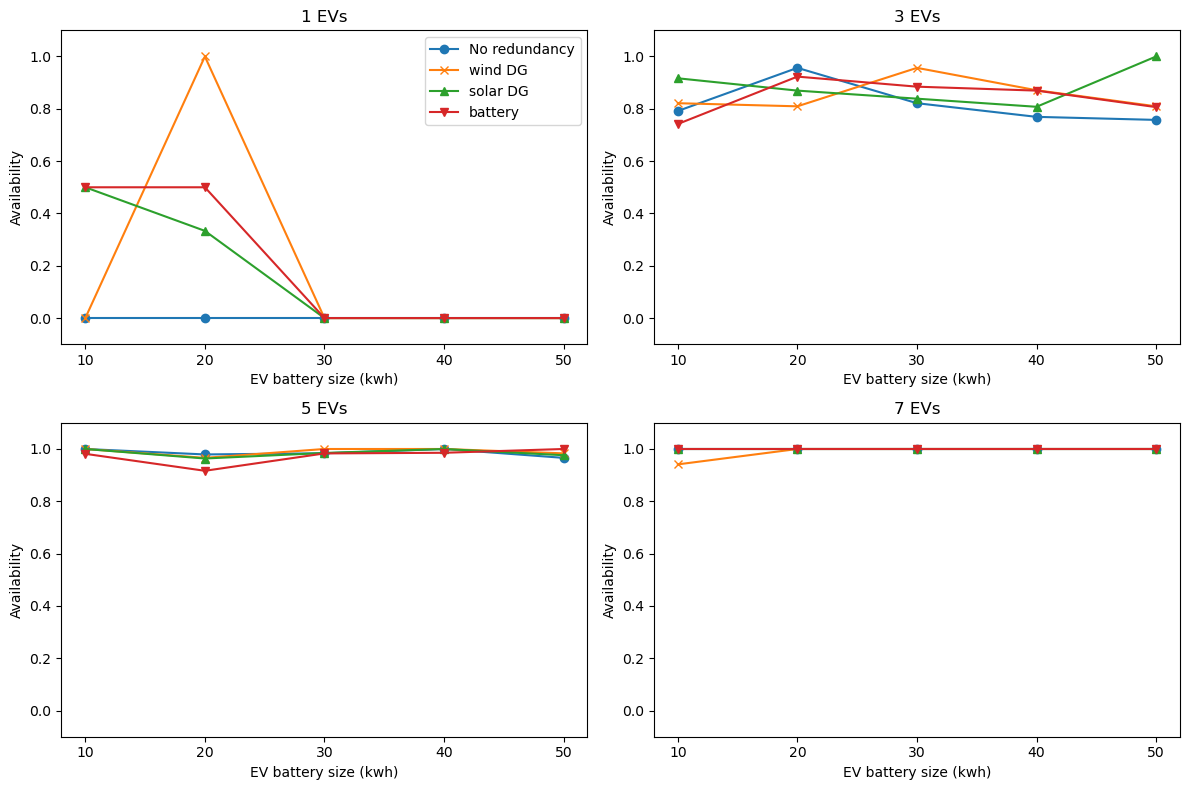

In [697]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, axes = plt.subplots(2,2)

n_ev_list=[1,3,5,7]

style_dict={
    0:'o-',
    1:'x-',
    2:'^-',
    3:'v-'
}

axes_dict={
    n_ev_list[0]:[0,0],
    n_ev_list[1]:[0,1],
    n_ev_list[2]:[1,0],
    n_ev_list[3]:[1,1]
}


for n_ev in n_ev_list:
    to_plot_dict={
    'nothing':[],
    'wind':[],
    'solar':[],
    'battery':[],
    }   
    for ev_battery_size in ev_battery_size_list:
        DBN_SG=final_dbn_dict[ev_battery_size]
        solver = VariableElimination(DBN_SG)

        # no redundancy 
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['nothing'].append(np.mean(mean_list))

        # wind
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):1,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['wind'].append(np.mean(mean_list))

        # solar
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):1,'beta_battery_{}'.format(t):0,'receives_energy_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['solar'].append(np.mean(mean_list))

        # battery
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):1,'receives_energy_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['battery'].append(np.mean(mean_list))
            
    axes_list=axes_dict[n_ev]
    axes[axes_list[0]][axes_list[1]].plot(ev_battery_size_list,to_plot_dict['nothing'],style_dict[0],label='No redundancy')
    axes[axes_list[0]][axes_list[1]].plot(ev_battery_size_list,to_plot_dict['wind'],style_dict[1],label='wind DG')
    axes[axes_list[0]][axes_list[1]].plot(ev_battery_size_list,to_plot_dict['solar'],style_dict[2],label='solar DG')
    axes[axes_list[0]][axes_list[1]].plot(ev_battery_size_list,to_plot_dict['battery'],style_dict[3],label='battery')
    axes[axes_list[0]][axes_list[1]].set_xlabel('EV battery size (kwh)')
    axes[axes_list[0]][axes_list[1]].set_ylabel('Availability')
    axes[axes_list[0]][axes_list[1]].set_title('{} EVs'.format(n_ev))
    axes[axes_list[0]][axes_list[1]].set_ylim([-0.1,1.1])
    axes[axes_list[0]][axes_list[1]].set_xticks(ev_battery_size_list)

axes[0][0].legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]

DBN_SG=dbn_sg_dict[0]
solver = VariableElimination(DBN_SG)

max_n_ev=6




plt.legend()
plt.xlabel('Number of EVs',fontsize=14)
plt.ylabel('Probability that sector attends demand',fontsize=14)
plt.xticks(range(max_n_ev+1),fontsize=14)
plt.show()

# Changing failure rate

In [745]:
failure_rate_list=[0.2,0.4,0.6,0.8,1]
sector=6
final_dbn_dict_failure_rate={}
time_horizon=12
max_n_ev=10

for carregamento in failure_rate_list: 
    model_dict=build_model(failure_rate=0.01,repair_rate=0,average_demand=40,carregamento=carregamento,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50)
    final_dbn_dict_failure_rate[carregamento]=create_dbn_from_model(model_dict,time_horizon=time_horizon,bus_idx=sector,num_samples=1000,num_chains=4,max_n_ev=max_n_ev)

########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883
########## BUS 3 ##########
0.08885573063674057


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


availability test! 0.7142857142857143
better availability test! 0.9444444444444444
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


availability test! 1.0
better availability test! 0.8181818181818182
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883
########## BUS 3 ##########
0.08885573063674057


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 0.7692307692307693
better availability test! 0.8181818181818182
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883
########## BUS 3 ##########
0.08885573063674057


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245
########## BUS 6 ##########
0.1823725814252967


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364
########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 11 ##########
0.2625970813747521
########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 0.8333333333333334
########## BUS 0 ##########
0.31252229681759247
########## BUS 1 ##########
0.12147441416653862
########## BUS 2 ##########
0.14045022990500883


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

########## BUS 3 ##########
0.08885573063674057
########## BUS 4 ##########
0.3348739771645238
########## BUS 5 ##########
0.14235282910141245


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 6 ##########
0.1823725814252967
########## BUS 7 ##########
0.16907007561897963
########## BUS 8 ##########
0.13451480286222364


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarni

########## BUS 9 ##########
0.10627705105292039
########## BUS 10 ##########
0.2703709838360287
########## BUS 11 ##########
0.2625970813747521


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


########## BUS 12 ##########
0.45146154082032114


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [daily_mileage, arrival_time, departure_time, wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


availability test! 0.8823529411764706
better availability test! 0.8888888888888888


C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_5708\3443750250.py:191: DeprecationWarning: `product` is depr

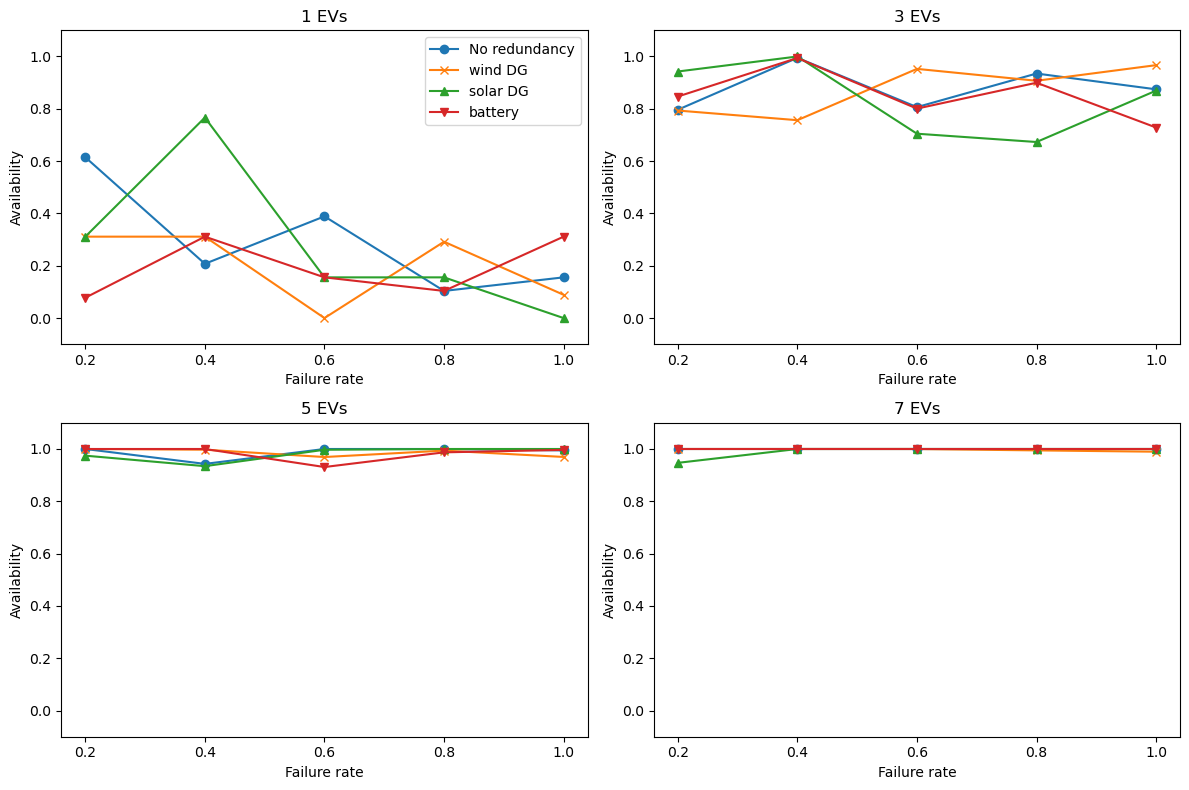

In [746]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, axes = plt.subplots(2,2)

n_ev_list=[1,3,5,7]

style_dict={
    0:'o-',
    1:'x-',
    2:'^-',
    3:'v-'
}

axes_dict={
    n_ev_list[0]:[0,0],
    n_ev_list[1]:[0,1],
    n_ev_list[2]:[1,0],
    n_ev_list[3]:[1,1]
}


for n_ev in n_ev_list:
    to_plot_dict={
    'nothing':[],
    'wind':[],
    'solar':[],
    'battery':[],
    }   
    for failure_rate in failure_rate_list:
        DBN_SG=final_dbn_dict_failure_rate[failure_rate]
        solver = VariableElimination(DBN_SG)

        # no redundancy 
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['nothing'].append(np.mean(mean_list))

        # wind
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):1,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['wind'].append(np.mean(mean_list))

        # solar
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):1,'beta_battery_{}'.format(t):0})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['solar'].append(np.mean(mean_list))

        # battery
        mean_list=[]
        for t in range(time_horizon):
            result = solver.query(variables=['availability_{}'.format(t)],evidence={'beta_ev_{}'.format(t):n_ev,'beta_wind_{}'.format(t):0,'beta_solar_{}'.format(t):0,'beta_battery_{}'.format(t):1})
            if(np.isnan(result.values[1])):
                mean_list.append(0)
            else:
                mean_list.append(result.values[1])

        to_plot_dict['battery'].append(np.mean(mean_list))
            
    axes_list=axes_dict[n_ev]
    axes[axes_list[0]][axes_list[1]].plot(failure_rate_list,to_plot_dict['nothing'],style_dict[0],label='No redundancy')
    axes[axes_list[0]][axes_list[1]].plot(failure_rate_list,to_plot_dict['wind'],style_dict[1],label='wind DG')
    axes[axes_list[0]][axes_list[1]].plot(failure_rate_list,to_plot_dict['solar'],style_dict[2],label='solar DG')
    axes[axes_list[0]][axes_list[1]].plot(failure_rate_list,to_plot_dict['battery'],style_dict[3],label='battery')
    axes[axes_list[0]][axes_list[1]].set_xlabel('Failure rate')
    axes[axes_list[0]][axes_list[1]].set_ylabel('Availability')
    axes[axes_list[0]][axes_list[1]].set_title('{} EVs'.format(n_ev))
    axes[axes_list[0]][axes_list[1]].set_ylim([-0.1,1.1])
    axes[axes_list[0]][axes_list[1]].set_xticks(failure_rate_list)

axes[0][0].legend()
plt.tight_layout()
plt.show()

In [744]:
final_dbn_dict_failure_rate

{1: <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x238e8c0c950>}

# Influence of individual EV user behavior
* what if everyone decides to charge up at the same time? effect of this in the final availability of the system


In [4]:
def build_model(failure_rate=0.01,repair_rate=0.4,average_demand=40,carregamento=0.8,ev_battery_size=24,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=10,bus_idx=0,individual_user_dict=None,daily_mileage_list=None):  
    #hiperparameters 
    # failure rate and repair rate of the system 
    failure_rate=0.01 
    repair_rate=0.5
    net=pp.from_pickle('londrina_por_setores.p')



    # wind speed (ref: Optimal Integrated Energy System Planning With DG Uncertainty Affine Model and Carbon Emissions Charges)
    scale_weibull=9.86 #shape
    shape_weibull=1.56 #scale
    v_ci=4 #cut-in wind speed
    v_ra=10 #rated wind speed
    v_co=22 #cut-out wind speed
    p_ra=300 #rated power of WT (varia entre 300 e 250 no artigo)

    # solar radiation (ref: Optimal Integrated Energy System Planning With DG Uncertainty Affine Model and Carbon Emissions Charges)
    a=7.5
    b=16.3
    i_max=2.9
    i_min=1.9

    # other solar radiations parameters (ref: Hybrid solar/wind power system probabilistic modelling for long-term performance assessment)
    sr_area=5 #typical area 

    #load deviation (ref: Automated Generation Algorithm for Synthetic Medium Voltage Radial Distribution Systems)
    loc=-0.001
    scale=0.002
    shape=1.46
    deviation=scipy.stats.nct(df=1,nc=shape,loc=loc,scale=scale).rvs(1)[0]

    # battery modelling (ref: A novel approach for optimal energy resources mixing in nuclear-renewable microgrids using probabilistic energy modelling method)
    n_cell=1
    a_d=35
    eff_inverter=0.95
    eff_battery=0.85
    dod=0.80
    d_max=100 #maximum distance

    ## EV modelling (ref: Probabilistic estimation of plug-in electric vehicles charging load profile)
    # maximum number of ev is defined before simulations

    # daily mileage is weibull:
    a_dm=32.029
    b_dm=1.23451

    # departure time is weibull
    a_dt=7.67
    b_dt=21.83

    # arrival time is generalized extreme value (cant model in pymc so I will use just weibull)
    # k_gev=-0.06
    #sigma_gev=0.85
    #mu_gev=17.3
    a_at=0.85
    b_at=17.3

    # current battery sizes for EV (ref: Probabilistic estimation of plug-in electric vehicles charging load profile)
    consumption_rate=0.23 #kwh/min

    #final values for mu and sigma over time
    mu_dict={
        '17':2885.1,
        '18':2493.9,
        '19':1818.6,
        '20':1105.05,
        '21':570.6,
        '22':263.25,
        '23':109.5,
        '24':40.35
    }

    sigma_dict={
        '17':51.8404,
        '18':121.435,
        '19':149.519,
        '20':142.494,
        '21':110.338,
        '22':87.7063,
        '23':61.691,
        '24':36.1651
    }

    #max capacities
    max_p_wt=50 #rated power of WT
    max_p_pv=50 #rater power of solar radiation
    average_feeder_capacity=average_demand/carregamento

    #max_cap_battery=n_cell*a_d*average_demand/(eff_inverter*eff_battery*dod)
    max_cap_battery=50

    #model parameters
    num_samples=10000
    num_chains=4


    # DEFINE THE CURRENT TIME (later I will change this since I want to use DBN)
    current_time=20


    graph_net=top.create_nxgraph(net)

    tabular_cpd=[]

    islanding_prob=1
    for gen_bus in net.gen.bus:
        path_list=list(nx.all_simple_paths(graph_net,gen_bus,bus_idx))
        produtorio_paths=1
        for path in path_list:
            len_path=len(path)
            produtorio=1
            for bus_path in path:
                produtorio*=(1-failure_dict[bus_path]) # prob that a path is working
            produtorio_paths*=(1-produtorio) #prob that no path is working -> feeder can not attends demand of sector
        islanding_prob*=produtorio_paths # prob that no feeder can attend demand -> sector is islanded

    print('########## BUS {} ##########'.format(bus_idx))
    print(islanding_prob)
    
    with pm.Model() as model1:

        beta_wind = pm.Bernoulli('beta_wind', p=0.5)
        beta_solar = pm.Bernoulli('beta_solar', p=0.5)    
        beta_battery = pm.Bernoulli('beta_battery',p=0.5)
        receives_energy = pm.Bernoulli('receives_energy', p=1-islanding_prob)    

        #ev modelling (essa parte posso usar depois)
        #gev = pm.CustomDist('gev',k_gev,sigma_gev,mu_gev,logp=gev_logp)
        n_ev=pm.DiscreteUniform('n_ev',lower=0,upper=max_n_ev)
        beta_ev = pm.Bernoulli('beta_ev',p=0.5,shape=max_n_ev) #dps transformar isso num array pq quero modelar cada EV individualmente

        
        if(individual_user_dict==None):
            arrival_time=pm.Weibull('arrival_time',alpha=a_at,beta=b_at,shape=max_n_ev)
            departure_time=pm.Weibull('departure_time',alpha=a_dt,beta=b_dt,shape=max_n_ev)
        else:
            #arrival_time=pm.Deterministic('arrival_time',np.array(individual_user_dict['arrival']))
            #departure_time=pm.Deterministic('departure_time',np.array(individual_user_dict['departure']))
            arrival_time=np.array(individual_user_dict['arrival'])
            departure_time=np.array(individual_user_dict['departure'])

        if(daily_mileage_list==None):
            daily_mileage=pm.Weibull('daily_mileage',alpha=a_dm,beta=b_dm,shape=max_n_ev)
        else:
            daily_mileage=np.array(daily_mileage_list)



        soc=1-daily_mileage/d_max

        charging_time=(1-soc)*consumption_rate/60 #charging time in hours

        print('charging time',max_n_ev)

        #available_power=soc*ev_battery_size+(current_time-arrival_time)*consumption_rate*60
        available_power=soc*ev_battery_size
        

        power_ev=pm.Deterministic('power_ev_array',pm.math.switch(beta_ev<0.5,-soc*ev_battery_size,pm.math.switch(departure_time-arrival_time>charging_time,available_power,0)))


        wind = pm.Weibull('wind',alpha=shape_weibull,beta=scale_weibull)
        #solar = (i_max-i_min)*pm.Beta('solar',alpha=a,beta=b)+i_min
        solar = (i_max-i_min)*pm.Beta('solar',alpha=a,beta=b)+i_min

        #capacity_wind = pm.Bound('capacity_wind',pm.Normal.dist(mu=beta_wind*max_p_wt*(wind**3-v_ci**3)/(v_ra**3-v_ci**3),sigma=1),lower=0.0)
        #capacity_solar = pm.Bound('capacity_solar',pm.Normal.dist(mu=beta_solar*(max_p_pv/i_max)*solar,sigma=1),lower=0.0)
        #capacity_feeder = pm.Bound('capacity_feeder',pm.Normal.dist(mu=average_feeder_capacity,sigma=1),lower=0.0)

        value_wind=max_p_wt*(wind**3-v_ci**3)/(v_ra**3-v_ci**3)

        true_value_wind=pm.math.switch(wind<v_ci,0,pm.math.switch(wind>=v_ci,pm.math.switch(wind<v_ra,value_wind,max_p_wt),max_p_wt))
        true_value_solar=pm.math.switch(sr_area*solar>max_p_pv,max_p_pv,sr_area*solar)
    
        capacity_wind=pm.Deterministic('capacity_wind',beta_wind*pm.math.switch(true_value_wind<0,0,true_value_wind))
        capacity_solar=pm.Deterministic('capacity_solar',beta_solar*true_value_solar)
        capacity_feeder=pm.Deterministic('capacity_feeder',receives_energy*average_feeder_capacity)
        capacity_battery=pm.Deterministic('capacity_battery',pm.math.switch(beta_battery>0.5,0,max_cap_battery))

        demand_deviation = pm.StudentT('demand_deviation',mu=loc,sigma=scale,nu=shape) 
        demand = pm.Bound('demand',pm.Normal.dist(mu=(1+demand_deviation)*average_demand,sigma=1),lower=0.0)

        energy_balance_with_battery  = pm.Deterministic('energy_balance_with_battery',capacity_battery+capacity_feeder+capacity_solar+capacity_wind+pm.math.sum(power_ev)-demand)
        energy_balance_no_battery = pm.Deterministic('energy_balance_no_battery',capacity_feeder+capacity_solar+capacity_wind+pm.math.sum(power_ev)-demand)
    return model1

    

# Early Arrival (EA)
* how many EVs arrived earlier (at the same initial time) and this influence on the final system demand

In [7]:
max_n_ev=10
initial_time=0
arrival_interval=1
time_horizon=12
sector=0
stay_hour=1
failure_rate=0.01
repair_rate=0.4
individual_user_dict={}
final_dbn_dict_ea={}
model_dict_ea={}
trace_dict_ea={}

for n_ev in range(10):
    print('############## stay hour {} ############'.format(stay_hour))
    
    individual_user_dict[n_ev]={}
    arrival_list=[initial_time]*n_ev+[(initial_time+arrival_interval*i) for i in range(1,max_n_ev-n_ev+1)]
    individual_user_dict[n_ev]['arrival']=arrival_list
    individual_user_dict[n_ev]['departure']=[arrival_list[i]+stay_hour for i in range(max_n_ev)]

    model_dict_ea[n_ev]=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict[n_ev])
    [final_dbn_dict_ea[n_ev],trace_dict_ea[n_ev]]=create_dbn_from_model({sector:model_dict_ea[n_ev]},time_horizon=time_horizon,bus_idx=sector,num_samples=10000,num_chains=4,max_n_ev=max_n_ev,return_trace=True)


############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


NameError: name 'create_dbn_from_model' is not defined

## EA: effect on trace

In [208]:

az.summary(trace_dict_ea[1],var_names=['energy_balance_no_battery','energy_balance_with_battery'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,10.956,156.307,-286.790,305.529,1.302,2.555,14217.0,3235.0,1.0
energy_balance_with_battery,35.694,158.317,-238.498,355.972,1.319,2.467,14408.0,3536.0,1.0


In [209]:
az.summary(trace_dict_ea[3],var_names=['energy_balance_no_battery','energy_balance_with_battery'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,11.853,163.196,-287.981,307.630,1.360,2.550,14408.0,3597.0,1.0
energy_balance_with_battery,36.678,165.114,-286.831,318.959,1.376,2.474,14408.0,3613.0,1.0


In [210]:
az.summary(trace_dict_ea[6],var_names=['energy_balance_no_battery','energy_balance_with_battery'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,12.185,159.166,-286.865,306.999,1.326,2.617,14408.0,3410.0,1.0
energy_balance_with_battery,37.085,161.811,-240.496,358.466,1.348,2.593,14408.0,3130.0,1.0


# EA: Effect on HDI

Text(0.5, 1.0, 'oi')

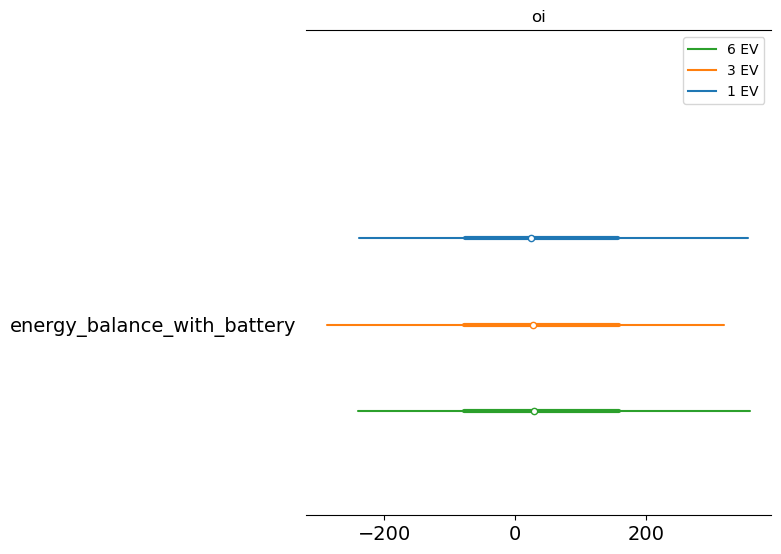

In [211]:
trace_list=[trace_dict_ea[1].posterior['energy_balance_with_battery'],
            trace_dict_ea[3].posterior['energy_balance_with_battery'],
            trace_dict_ea[6].posterior['energy_balance_with_battery']]

az.plot_forest(trace_list,combined=True,model_names=['1 EV','3 EV','6 EV'])
plt.title('oi')

## EA: Effect on availability

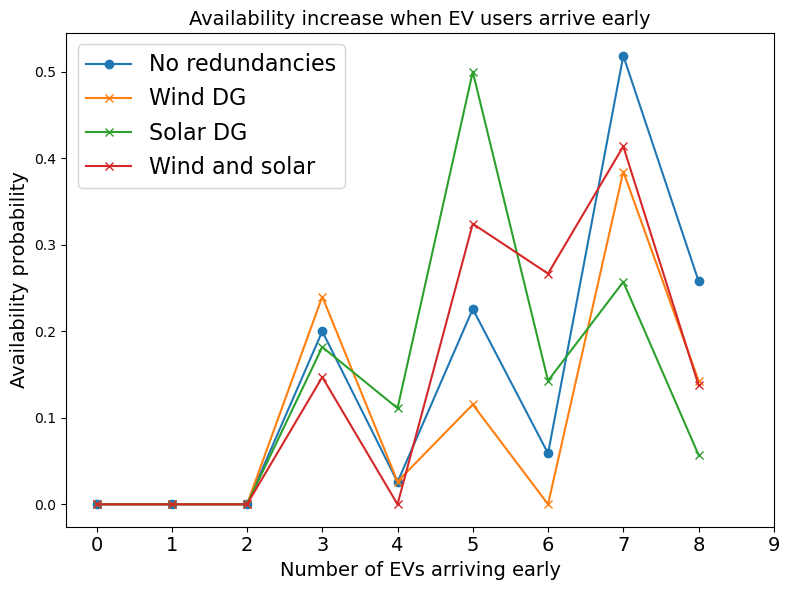

In [234]:
plt.rcParams['figure.figsize'] = [8, 6]
max_n_ev=6

style_dict={
    0:'o-',
    1:'x-',
    2:'^-'
}
to_plot_list=[]
n_ev_list=list(final_dbn_dict_ea.keys())[0:-1]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ea[n_ev])

    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[0],label='No redundancies')



# wind DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ea[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind DG')

# solar DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ea[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Solar DG')


# wind and solar
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ea[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind and solar')



plt.legend(fontsize=16)
plt.xlabel('Number of EVs arriving early',fontsize=14)
plt.ylabel('Availability probability',fontsize=14)
plt.xticks(list(final_dbn_dict_ea.keys()),fontsize=14)
plt.title('Availability increase when EV users arrive early',fontsize=14)
plt.tight_layout()
plt.show()

# More mileage
* what happens if EVs drive more before arriving at the charging station (but still arrive at the same time)

In [215]:
max_n_ev=10
initial_time=0
arrival_interval=1
time_horizon=12
sector=0
stay_hour=1
failure_rate=0.01
repair_rate=0.4
mileage_multiplier=4
individual_user_dict={}
final_dbn_dict_mileage={}
model_dict_mileage={}
trace_dict_mileage={}

for n_ev in range(10):
    print('############## stay hour {} ############'.format(stay_hour))
    
    # arrival and departure of each individual user
    individual_user_dict[n_ev]={}
    arrival_list=[initial_time]*n_ev+[(initial_time+arrival_interval*i) for i in range(1,max_n_ev-n_ev+1)]
    individual_user_dict[n_ev]['arrival']=arrival_list
    individual_user_dict[n_ev]['departure']=[arrival_list[i]+stay_hour for i in range(max_n_ev)]

    # daily mileage list for each individual user
    daily_mileage_list=[1213]*n_ev+[1213*mileage_multiplier]*(max_n_ev-n_ev)




    model_dict_mileage[n_ev]=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict[n_ev],daily_mileage_list=daily_mileage_list)
    [final_dbn_dict_mileage[n_ev],trace_dict_mileage[n_ev]]=create_dbn_from_model({sector:model_dict_mileage[n_ev]},time_horizon=time_horizon,bus_idx=sector,num_samples=1000,num_chains=4,max_n_ev=max_n_ev,return_trace=True)


############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


availability test! 0.95
better availability test! 1.0
############## stay hour 1 ############


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


availability test! 0.8333333333333334
better availability test! 1.0
############## stay hour 1 ############


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

In [216]:
az.summary(trace_dict_mileage[1],var_names=['energy_balance_no_battery','energy_balance_with_battery'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,-185.772,7247.719,-12427.562,12458.020,60.380,120.708,14408.0,3338.0,1.0
energy_balance_with_battery,-161.085,7247.909,-12427.800,12495.042,60.382,120.773,14408.0,3310.0,1.0


In [217]:

az.summary(trace_dict_mileage[5],var_names=['energy_balance_no_battery','energy_balance_with_battery'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,85.915,5449.265,-9885.455,10234.449,45.398,90.46,14408.0,3448.0,1.0
energy_balance_with_battery,110.928,5448.689,-9840.365,10271.257,45.393,90.37,14408.0,3428.0,1.0


In [218]:

az.summary(trace_dict_mileage[9],var_names=['energy_balance_no_battery','energy_balance_with_battery'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
energy_balance_no_battery,40.209,2924.941,-5199.471,4117.777,24.368,48.829,14408.0,3190.0,1.0
energy_balance_with_battery,65.209,2925.971,-5189.504,4168.562,24.376,48.807,14408.0,3113.0,1.0


In [230]:
plt.rcParams['figure.figsize'] = [8, 6]

max_n_ev=8


style_dict={
    0:'o-',
    1:'x-',
    2:'^-'
}
to_plot_list=[]
n_ev_list=list(final_dbn_dict_ea.keys())[1:-1]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_mileage[n_ev])

    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[0],label='No redundancies')



# wind DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_mileage[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind DG')

# solar DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_mileage[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Solar DG')


# wind and solar
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_mileage[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind and solar')



plt.legend(fontsize=16)
plt.xlabel('Number of EVs with increased mileage',fontsize=14)
plt.ylabel('Availability probability',fontsize=14)
plt.xticks(list(final_dbn_dict_ea.keys()),fontsize=14)
plt.title('Availability increase when EV users increase their mileage',fontsize=14)
plt.tight_layout()
plt.show()

KeyError: 1

# Departuring late

In [224]:
max_n_ev=10
initial_time=0
arrival_interval=1
time_horizon=12
sector=0
stay_hour=1
late_stay_hour=8
failure_rate=0.01
repair_rate=0.4
mileage_multiplier=4
individual_user_dict={}
final_dbn_dict_ld={}
model_dict_ld={}
trace_dict_ld={}

for n_ev in range(10):
    print('############## stay hour {} ############'.format(stay_hour))
    
    # arrival and departure of each individual user
    individual_user_dict[n_ev]={}
    arrival_list=[(initial_time+arrival_interval*i) for i in range(max_n_ev)]
    individual_user_dict[n_ev]['arrival']=arrival_list
    individual_user_dict[n_ev]['departure']=[arrival_list[i]+late_stay_hour for i in range(n_ev)]+[arrival_list[i]+stay_hour for i in range(max_n_ev-n_ev)]

    # daily mileage list for each individual user
    daily_mileage_list=[1213]*max_n_ev




    model_dict_ld[n_ev]=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict[n_ev],daily_mileage_list=daily_mileage_list)
    [final_dbn_dict_ld[n_ev],trace_dict_ld[n_ev]]=create_dbn_from_model({sector:model_dict_ld[n_ev]},time_horizon=time_horizon,bus_idx=sector,num_samples=1000,num_chains=4,max_n_ev=max_n_ev,return_trace=True)


############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


availability test! 1.0
better availability test! 1.0
############## stay hour 1 ############
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


availability test! 1.0
better availability test! 1.0


C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_26548\4069219241.py:191: DeprecationWarning: `product` is d

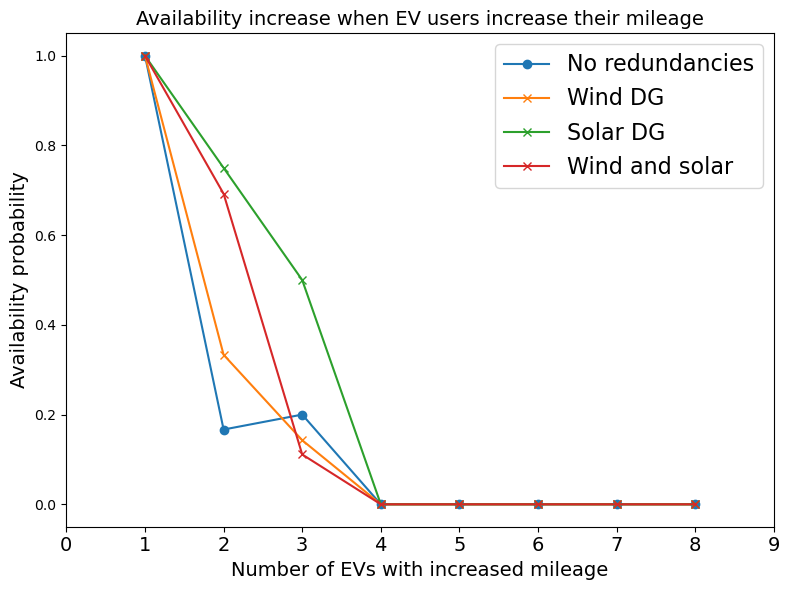

In [229]:
plt.rcParams['figure.figsize'] = [8, 6]

max_n_ev=8
style_dict={
    0:'o-',
    1:'x-',
    2:'^-'
}
to_plot_list=[]
n_ev_list=list(final_dbn_dict_ld.keys())[1:-1]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ld[n_ev])

    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[0],label='No redundancies')



# wind DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ld[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind DG')

# solar DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ld[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Solar DG')


# wind and solar
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_ld[n_ev])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=max_n_ev
        evidence['beta_wind_{}'.format(t)]=1
        evidence['beta_solar_{}'.format(t)]=1
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Wind and solar')



plt.legend(fontsize=16)
plt.xlabel('Number of EVs with increased mileage',fontsize=14)
plt.ylabel('Availability probability',fontsize=14)
plt.xticks(list(final_dbn_dict_ea.keys()),fontsize=14)
plt.title('Availability increase when EV users increase their mileage',fontsize=14)
plt.tight_layout()
plt.show()

# Effect of a single user decision
Possible user decisions are:
* arrive early
* departure late
* more mileage

what happens if a single EV do any of those things? (keeping the number of maximum evs fixed)

In [10]:

max_n_ev=10
n_ev=1
initial_time=6
arrival_interval=1
time_horizon=12
sector=0
stay_hour=1
late_stay_hour=8
failure_rate=0.01
repair_rate=0.4
mileage_multiplier=4
num_samples=10000

final_dbn_dict_single_user={}
model_dict_single_user={}
trace_dict_single_user={}

#Early arrival
arrival_list=[0]*n_ev+[(initial_time+arrival_interval*i) for i in range(1,max_n_ev-n_ev+1)]
individual_user_dict={}
individual_user_dict['arrival']=arrival_list
individual_user_dict['departure']=[arrival_list[i]+stay_hour for i in range(max_n_ev)]

daily_mileage_list=[1213]*max_n_ev


model_dict_single_user['ea']=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict,daily_mileage_list=daily_mileage_list)
[final_dbn_dict_single_user['ea'],trace_dict_single_user['ea']]=create_dbn_from_model({sector:model_dict_single_user['ea']},time_horizon=time_horizon,bus_idx=sector,num_samples=num_samples,num_chains=4,max_n_ev=max_n_ev,return_trace=True)




# late departure
individual_user_dict={}
arrival_list=[(initial_time+arrival_interval*i) for i in range(max_n_ev)]
individual_user_dict['arrival']=arrival_list
individual_user_dict['departure']=[arrival_list[i]+late_stay_hour for i in range(n_ev)]+[arrival_list[i]+stay_hour for i in range(max_n_ev-n_ev)]

daily_mileage_list=[1213]*max_n_ev


model_dict_single_user['ld']=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict,daily_mileage_list=daily_mileage_list)
[final_dbn_dict_single_user['ld'],trace_dict_single_user['ld']]=create_dbn_from_model({sector:model_dict_single_user['ld']},time_horizon=time_horizon,bus_idx=sector,num_samples=num_samples,num_chains=4,max_n_ev=max_n_ev,return_trace=True)






########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


availability test! 1.0
better availability test! 1.0
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:191: DeprecationWarning: `product` is depr

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.


availability test! 1.0
better availability test! 1.0


C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:191: DeprecationWarning: `product` is depr

In [11]:
# mileage
individual_user_dict={}
arrival_list=[(initial_time+arrival_interval*i) for i in range(max_n_ev)]
individual_user_dict['arrival']=arrival_list
individual_user_dict['departure']=[arrival_list[i]+stay_hour for i in range(max_n_ev)]

daily_mileage_list=[1213*mileage_multiplier]*n_ev+[1213]*(max_n_ev-n_ev)

model_dict_single_user['mileage']=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict,daily_mileage_list=daily_mileage_list)
[final_dbn_dict_single_user['mileage'],trace_dict_single_user['mileage']]=create_dbn_from_model({sector:model_dict_single_user['mileage']},time_horizon=time_horizon,bus_idx=sector,num_samples=num_samples,num_chains=4,max_n_ev=max_n_ev,return_trace=True)

# nothing
daily_mileage_list=[1213]*max_n_ev
individual_user_dict={}
arrival_list=[(initial_time+arrival_interval*i) for i in range(max_n_ev)]
individual_user_dict['arrival']=arrival_list
individual_user_dict['departure']=[arrival_list[i]+stay_hour for i in range(max_n_ev)]



model_dict_single_user['nothing']=build_model(failure_rate=failure_rate,repair_rate=repair_rate,average_demand=40,carregamento=0.8,ev_battery_size=50,max_p_wt=50,max_p_pv=50,max_cap_battery=50,max_n_ev=max_n_ev,individual_user_dict=individual_user_dict,daily_mileage_list=daily_mileage_list)
[final_dbn_dict_single_user['nothing'],trace_dict_single_user['nothing']]=create_dbn_from_model({sector:model_dict_single_user['nothing']},time_horizon=time_horizon,bus_idx=sector,num_samples=num_samples,num_chains=4,max_n_ev=max_n_ev,return_trace=True)


########## BUS 0 ##########
0.31252229681759247
charging time 10


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [beta_wind, beta_solar, beta_battery, receives_energy, beta_ev]
>Metropolis: [n_ev]
>NUTS: [wind, solar, demand_deviation, demand]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 73 seconds.


availability test! 1.0
better availability test! 1.0
########## BUS 0 ##########
0.31252229681759247
charging time 10


C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:191: DeprecationWarning: `product` is depr

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.


availability test! 1.0
better availability test! 1.0


C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:185: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  availability_cpd=TabularCPD('availability_{}'.format(t),2,state_cpd,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:186: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  battery_state_cpd=TabularCPD('battery_state_{}'.format(t),3,battery_state_cpd_list,evidence=['receives_energy_{}'.format(t),'beta_wind_{}'.format(t),'beta_solar_{}'.format(t),'beta_battery_{}'.format(t),'beta_ev_{}'.format(t)],evidence_card=[2,2,2,2,max_n_ev+1])
C:\Users\hoc\AppData\Local\Temp\ipykernel_8752\4069219241.py:191: DeprecationWarning: `product` is depr

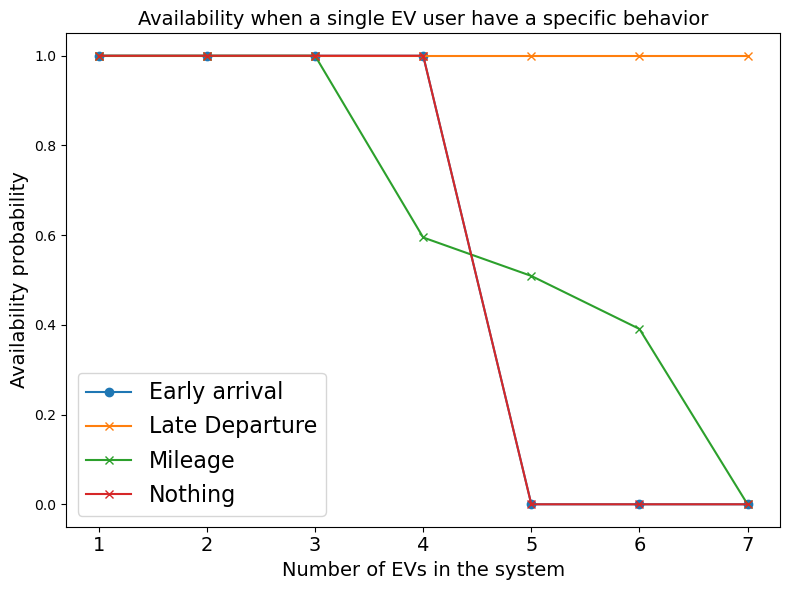

In [16]:
plt.rcParams['figure.figsize'] = [8, 6]

single_user_df=pd.DataFrame(columns=['n_ev','availability','behavior'])


max_n_ev=8
style_dict={
    0:'o-',
    1:'x-',
    2:'^-'
}
to_plot_list=[]
n_ev_list=range(1,8)
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_single_user['ea'])

    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

    single_user_df.loc[len(single_user_df)]=[n_ev,np.mean(probability_list),'early arrival']

plt.plot(n_ev_list,to_plot_list,style_dict[0],label='Early arrival')



# wind DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_single_user['ld'])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

    single_user_df.loc[len(single_user_df)]=[n_ev,np.mean(probability_list),'late departure']

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Late Departure')

# solar DG
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_single_user['mileage'])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

    single_user_df.loc[len(single_user_df)]=[n_ev,np.mean(probability_list),'mileage']

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Mileage')


# wind and solar
to_plot_list=[]
for n_ev in n_ev_list:
    solver = VariableElimination(final_dbn_dict_single_user['nothing'])
    probability_list=[]
    for t in range(time_horizon):
        evidence={}
        evidence['receives_energy_{}'.format(t)]=0  
        evidence['beta_ev_{}'.format(t)]=n_ev
        evidence['beta_wind_{}'.format(t)]=0
        evidence['beta_solar_{}'.format(t)]=0
        evidence['beta_battery_{}'.format(t)]=1
        result_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        evidence['beta_battery_{}'.format(t)]=0
        result_no_charged_battery = solver.query(variables=['availability_{}'.format(t)],evidence=evidence)
        #value=result_charged_battery.values[1]-result_no_charged_battery.values[1]
        value=result_charged_battery.values[1]
        if(np.isnan(value)):
            probability_list.append(0)
        else:
            probability_list.append(value)           
    to_plot_list.append(np.mean(probability_list))

    single_user_df.loc[len(single_user_df)]=[n_ev,np.mean(probability_list),'nothing']

plt.plot(n_ev_list,to_plot_list,style_dict[1],label='Nothing')



plt.legend(fontsize=16)
plt.xlabel('Number of EVs in the system',fontsize=14)
plt.ylabel('Availability probability',fontsize=14)
plt.xticks(n_ev_list,fontsize=14)
plt.title('Availability when a single EV user have a specific behavior',fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fu

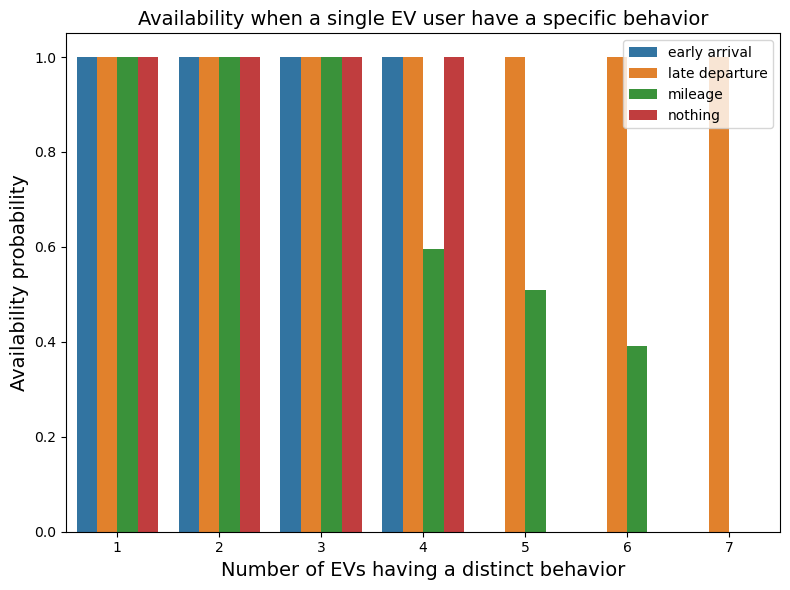

In [18]:
sns.barplot(single_user_df['n_ev'],y=single_user_df['availability'],hue=single_user_df['behavior'])
plt.legend(fontsize=16)
plt.xlabel('Number of EVs having a distinct behavior',fontsize=14)
plt.ylabel('Availability probability',fontsize=14)
plt.title('Availability when a single EV user have a specific behavior',fontsize=14)
plt.tight_layout()
plt.legend()
plt.show()


# posterior distribution of energy balance

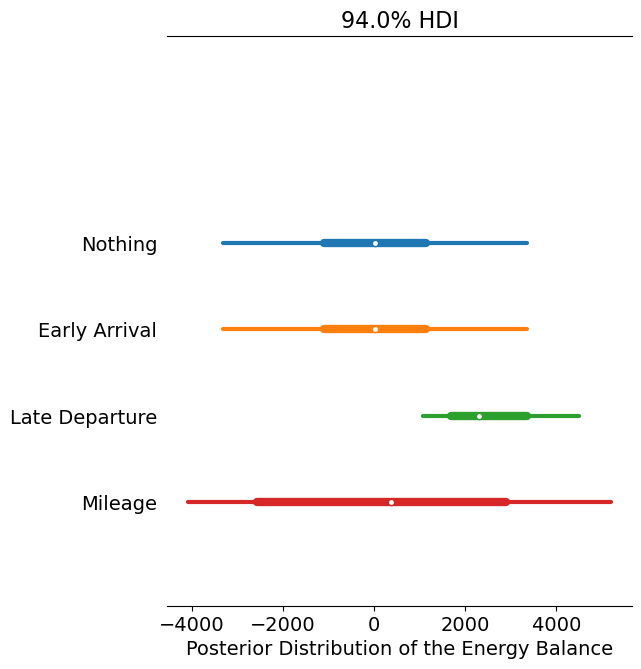

In [13]:
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={"energy_balance_no_battery": ''})

trace_list=[trace_dict_single_user['nothing'].posterior['energy_balance_no_battery'],
            trace_dict_single_user['ea'].posterior['energy_balance_no_battery'],
            trace_dict_single_user['ld'].posterior['energy_balance_no_battery'],
            trace_dict_single_user['mileage'].posterior['energy_balance_no_battery']]

az.plot_forest(trace_list,combined=True,model_names=['Nothing','Early Arrival','Late Departure','Mileage'],linewidth=3,labeller=labeller,legend=False)
plt.xlabel('Posterior Distribution of the Energy Balance',fontsize=14)
#plt.tight_layout()
plt.show()


In [25]:
model_dict_ea

{0:                   beta_wind ~ Bernoulli(0.5)
                  beta_solar ~ Bernoulli(0.5)
                beta_battery ~ Bernoulli(0.5)
             receives_energy ~ Bernoulli(0.687)
                        n_ev ~ DiscreteUniform(f(), f())
                     beta_ev ~ Bernoulli(0.5)
               daily_mileage ~ Weibull(32, 1.23)
                        wind ~ Weibull(1.56, 9.86)
                       solar ~ Beta(7.5, 16.3)
            demand_deviation ~ StudentT(1.46, -0.001, 0.002)
                      demand ~ Bound(Normal(f(demand_deviation), 1), 0, inf)
              power_ev_array ~ Deterministic(f(beta_ev, daily_mileage))
               capacity_wind ~ Deterministic(f(beta_wind, wind))
              capacity_solar ~ Deterministic(f(beta_solar, solar))
             capacity_feeder ~ Deterministic(f(receives_energy))
            capacity_battery ~ Deterministic(f(beta_battery))
 energy_balance_with_battery ~ Deterministic(f(demand, beta_wind, beta_ev, beta_solar, recei